In [1]:
%matplotlib inline
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as colors
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
from matplotlib.colors import LinearSegmentedColormap
from scipy import stats
import scikit_posthocs as sp
import sys

In [18]:
matrixMalEX="data_GG.csv"
matrixMal="data_GM.csv"
matrixIt="data_L.csv"
matrixIt_Total="data_L_Total.csv"
n_qty=6 #CAMBIAR SEGUN LA CANTIDAD DE NODOS USADOS
n_groups= 2
repet = 10 #CAMBIAR EL NUMERO SEGUN NUMERO DE EJECUCIONES POR CONFIG
time_constant = False # Cambiar segun el speedUp usado
speedup = 0.66 # Porcentaje del speedup ideal

p_value = 0.05
values = [2, 10, 20, 40]
#                      WORST          BEST
dist_names = ['null', 'BalancedFit', 'CompactFit']

processes = [1,10,20,40,80,120]

labelsP = [['(2,2)', '(2,10)', '(2,20)', '(2,40)'],['(10,2)', '(10,10)', '(10,20)', '(10,40)'],
          ['(20,2)', '(20,10)', '(20,20)', '(20,40)'],['(40,2)', '(40,10)', '(40,20)', '(40,40)']]
labelsP_J = ['(2,2)', '(2,10)', '(2,20)', '(2,40)','(10,2)', '(10,10)', '(10,20)', '(10,40)',
              '(20,2)', '(20,10)', '(20,20)', '(20,40)','(40,2)', '(40,10)', '(40,20)', '(40,40)']
positions = [321, 322, 323, 324, 325]
positions_small = [221, 222, 223, 224]

labels = ['(1,10)', '(1,20)', '(1,40)','(1,80)','(1,120)',
            '(10,1)', '(10,20)', '(10,40)','(10,80)','(10,120)',
            '(20,1)',  '(20,10)','(20,40)','(20,80)','(20,120)',
            '(40,1)',  '(40,10)',  '(40,20)','(40,80)','(40,120)',
            '(80,1)',  '(80,10)',  '(80,20)', '(80,40)','(80,120)',
            '(120,1)', '(120,10)', '(120,20)','(120,40)','(120,80)']

labelsExpand = ['(1,10)', '(1,20)', '(1,40)','(1,80)','(1,120)',
               '(10,20)', '(10,40)','(10,80)','(10,120)',
               '(20,40)','(20,80)','(20,120)',
               '(40,80)','(40,120)',
               '(80,120)']
labelsShrink = ['(10,1)', 
               '(20,1)',  '(20,10)', 
               '(40,1)',  '(40,10)',  '(40,20)',
               '(80,1)',  '(80,10)',  '(80,20)', '(80,40)',
               '(120,1)', '(120,10)', '(120,20)','(120,40)','(120,80)']

labelsExpandOrdered = ['(1,10)', '(1,20)', '(10,20)',
                       '(1,40)','(10,40)','(20,40)',
                       '(1,80)','(10,80)','(20,80)','(40,80)',
                       '(1,120)', '(10,120)', '(20,120)','(40,120)','(80,120)']
labelsShrinkOrdered = ['(10,1)', '(20,1)', '(40,1)', '(80,1)', '(120,1)',
                '(20,10)',  '(40,10)',  '(80,10)',  '(120,10)', 
                '(40,20)', '(80,20)', '(120,20)',
                '(80,40)','(120,40)',
                '(120,80)']

labelsExpandIntra = ['(1,10)', '(1,20)','(10,20)']
labelsShrinkIntra = ['(10,1)', '(20,1)', '(20,10)']
labelsExpandInter = ['(1,40)','(1,80)', '(1,160)',
               '(10,40)','(10,80)', '(10,160)',
               '(20,40)','(20,80)', '(20,160)',
               '(40,80)', '(40,160)',
               '(80,160)']
labelsShrinkInter = ['(40,1)', '(40,10)', '(40,20)',
               '(80,1)', '(80,10)', '(80,20)','(80,40)',
               '(160,1)', '(160,10)', '(160,20)','(160,40)', '(160,80)']

                #0          #1                 #2                     #3
labelsMethods = ['Baseline', 'Baseline single','Baseline - Asynchronous','Baseline single - Asynchronous',
                 'Merge','Merge single','Merge - Asynchronous','Merge single - Asynchronous']
                 #4      #5             #6                 #7
colors_spawn = ['green','springgreen','blue','darkblue','red','darkred','darkgoldenrod','olive','violet']
linestyle_spawn = ['-', '--', '-.', ':']
markers_spawn = ['.','v','s','p', 'h','d','X','P','^']

OrMult_patch = mpatches.Patch(hatch='', facecolor='green', label='Baseline')
OrSing_patch = mpatches.Patch(hatch='', facecolor='springgreen', label='Baseline single')
OrPthMult_patch = mpatches.Patch(hatch='//', facecolor='blue', label='Baseline - Asyncrhonous')
OrPthSing_patch = mpatches.Patch(hatch='\\', facecolor='darkblue', label='Baseline single - Asyncrhonous')
MergeMult_patch = mpatches.Patch(hatch='||', facecolor='red', label='Merge')
MergeSing_patch = mpatches.Patch(hatch='...', facecolor='darkred', label='Merge single')
MergePthMult_patch = mpatches.Patch(hatch='xx', facecolor='yellow', label='Merge - Asyncrhonous')
MergePthSing_patch = mpatches.Patch(hatch='++', facecolor='olive', label='Merge single - Asyncrhonous')

handles_spawn = [OrMult_patch,OrSing_patch,OrPthMult_patch,OrPthSing_patch,MergeMult_patch,MergeSing_patch,MergePthMult_patch,MergePthSing_patch]

In [67]:
dfG = pd.read_csv( matrixMalEX )

dfG = dfG.drop(columns=dfG.columns[0])
dfG['S'] = dfG['N']
dfG['N'] = dfG['S'] + dfG['%Async']
dfG['%Async'] = (dfG['%Async'] / dfG['N']) * 100
dfG['%Async'] = dfG['%Async'].fillna(0)

if(n_qty == 1):
    group = dfG.groupby(['%Async', 'Cst', 'Css', 'Groups'])['TE']
    group2 = dfG.groupby(['%Async', 'Cst', 'Css', 'NP','NS'])['TE']
else:        
    group = dfG.groupby(['Dist', '%Async', 'Cst', 'Css', 'Groups'])['TE']
    group2 = dfG.groupby(['Dist', '%Async', 'Cst', 'Css', 'NP','NS'])['TE']

grouped_aggG = group.agg(['median'])
grouped_aggG.rename(columns={'median':'TE'}, inplace=True)

grouped_aggG2 = group2.agg(['median'])
grouped_aggG2.rename(columns={'median':'TE'}, inplace=True)

In [68]:
dfM = pd.read_csv( matrixMal )
dfM = dfM.drop(columns=dfM.columns[0])

dfM['S'] = dfM['N']
dfM['N'] = dfM['S'] + dfM['%Async']
dfM["TR"] = dfM["TC"] + dfM["TH"] + dfM["TS"] + dfM["TA"]
dfM['%Async'] = (dfM['%Async'] / dfM['N']) * 100

dfM['%Async'] = dfM['%Async'].fillna(0)
dfM['alpha'] = 1

#dfM = dfM.drop(dfM.loc[(dfM["Cst"] == 3) & (dfM["Css"] == 1) & (dfM["NP"] > dfM["NS"])].index)
#dfM = dfM.drop(dfM.loc[(dfM["Cst"] == 2) & (dfM["Css"] == 1) & (dfM["NP"] > dfM["NS"])].index)

if(n_qty == 1):
    groupM = dfM.groupby(['%Async', 'Cst', 'Css', 'NP', 'NS'])['TC', 'TH', 'TS', 'TA', 'TR', 'alpha']
else:
    groupM = dfM.groupby(['Dist', '%Async', 'Cst', 'Css', 'NP', 'NS'])['TC', 'TH', 'TS', 'TA', 'TR', 'alpha']

#group
grouped_aggM = groupM.agg(['median'])
grouped_aggM.columns = grouped_aggM.columns.get_level_values(0)

for cst_aux in [1,3]:
    for css_aux in [0,1]:
        for np_aux in processes:
            for ns_aux in processes:
                if np_aux != ns_aux:
                    grouped_aggM.loc[('2,2',0, cst_aux, css_aux, np_aux,ns_aux)]['alpha'] = \
                        grouped_aggM.loc[('2,2',0, cst_aux, css_aux, np_aux,ns_aux)]['TC'] / \
                        grouped_aggM.loc[('2,2',0, cst_aux-1, css_aux, np_aux,ns_aux)]['TC']
                    

/tmp/ipykernel_2692/2056908859.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  groupM = dfM.groupby(['Dist', '%Async', 'Cst', 'Css', 'NP', 'NS'])['TC', 'TH', 'TS', 'TA', 'TR', 'alpha']


In [69]:
dfL = pd.read_csv( matrixIt )
dfL = dfL.drop(columns=dfL.columns[0])

dfL['%Async'] = dfL['%Async'].fillna(0)
dfL['omega'] = 1

#dfL = dfL.drop(dfL.loc[(dfL["Cst"] == 3) & (dfL["Css"] == 1) & (dfL["NP"] > dfL["NS"])].index)
#dfL = dfL.drop(dfL.loc[(dfL["Cst"] == 2) & (dfL["Css"] == 1) & (dfL["NP"] > dfL["NS"])].index)

if(n_qty == 1):
    groupL = dfL[dfL['NS'] != 0].groupby(['Tt', '%Async', 'Cst', 'Css', 'NP', 'NS'])['Ti', 'To', 'omega']
else:
    groupL = dfL[dfL['NS'] != 0].groupby(['Tt', 'Dist', '%Async', 'Cst', 'Css', 'NP', 'NS'])['Ti', 'To', 'omega']

#group
grouped_aggL = groupL.agg(['median', 'count'])
grouped_aggL.columns = grouped_aggL.columns.get_level_values(0)
grouped_aggL.set_axis(['Ti', 'Iters', 'To', 'Iters2', 'omega', 'omega2'], axis='columns', inplace=True)
grouped_aggL['Iters'] = np.round(grouped_aggL['Iters']/repet)
grouped_aggL['Iters2'] = np.round(grouped_aggL['Iters2']/repet)

for cst_aux in [1,3]:
    for css_aux in [0,1]:
        for np_aux in processes:
            for ns_aux in processes:
                if np_aux != ns_aux:
                    grouped_aggL.loc[(1,2,0, cst_aux, css_aux, np_aux,ns_aux), 'omega'] = \
                        grouped_aggL.loc[(1,2,0, cst_aux, css_aux, np_aux,ns_aux)]['Ti'] / \
                        grouped_aggL.loc[(0,2,0, cst_aux, css_aux, np_aux,ns_aux)]['Ti']

/tmp/ipykernel_2692/1294489315.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  groupL = dfL[dfL['NS'] != 0].groupby(['Tt', 'Dist', '%Async', 'Cst', 'Css', 'NP', 'NS'])['Ti', 'To', 'omega']


In [70]:
dfLT = pd.read_csv( matrixIt_Total )
dfLT = dfLT.drop(columns=dfLT.columns[0])

dfLT['%Async'] = dfLT['%Async'].fillna(0)
dfLT['ItA']= dfLT.Ti.apply(lambda x: list(x.replace('(','').replace(')','').split(',')))
dfLT['TiA']= dfLT.ItA.apply(lambda x: np.median(list(map(float,[y for y in x if y]))) )
dfLT['TiA']= dfLT['TiA'].fillna(0)
dfLT['ItA']= dfLT.ItA.apply(lambda x: len([y for y in x if y]))


#dfL = dfL.drop(dfL.loc[(dfL["Cst"] == 3) & (dfL["Css"] == 1) & (dfL["NP"] > dfL["NS"])].index)
#dfL = dfL.drop(dfL.loc[(dfL["Cst"] == 2) & (dfL["Css"] == 1) & (dfL["NP"] > dfL["NS"])].index)

if(n_qty == 1):
    groupLT = dfLT[dfLT['NS'] != 0].groupby(['%Async', 'Cst', 'Css', 'NP', 'NS'])['Sum', 'ItA']
else:
    groupLT = dfLT[dfLT['NS'] != 0].groupby(['Dist', '%Async', 'Cst', 'Css', 'NP', 'NS'])['Sum', 'ItA']

#group
grouped_aggLT = groupLT.agg(['median'])
grouped_aggLT.columns = grouped_aggLT.columns.get_level_values(0)
grouped_aggLT.set_axis(['Sum','ItA'], axis='columns', inplace=True)

/home/usuario/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/tmp/ipykernel_2692/3028104048.py:17: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  groupLT = dfLT[dfLT['NS'] != 0].groupby(['Dist', '%Async', 'Cst', 'Css', 'NP', 'NS'])['Sum', 'ItA']


In [71]:
tc_list = []
alpha_list = []
omega_list = []
ita_list = []
dfLT['index'] = dfLT.index
dfM['index'] = dfM.index
for cst_aux in [0,1,2,3]:
    for css_aux in [0,1]:
        for np_aux in processes:
            for ns_aux in processes:
                if np_aux != ns_aux:
                    dfLT_aux = dfLT[dfLT["NP"] == np_aux][dfLT["NS"] == ns_aux][dfLT["Cst"] == cst_aux][dfLT["Css"] == css_aux]
                    dfM_aux = dfM[dfM["NP"] == np_aux][dfM["NS"] == ns_aux][dfM["Css"] == css_aux]
                    if cst_aux == 1 or cst_aux == 3:
                        dfM_aux2= dfM_aux[dfM_aux["Cst"] == cst_aux-1]
                        dfM_aux2= dfM_aux2.sort_values(by=['TH'])
                    dfM_aux = dfM_aux[dfM_aux["Cst"] == cst_aux]
                    dfM_aux= dfM_aux.sort_values(by=['TH'])
                    index1_aux = dfM_aux.iloc[4]["index"]
                    index2_aux = dfM_aux.iloc[5]["index"]
                    
                    # Comprobar que es un metodo asincrono
                    if cst_aux == 1 or cst_aux == 3:
                        value_aux1 = dfM_aux[dfM_aux["index"] == index1_aux]['TC'].values
                        value_aux2 = dfM_aux[dfM_aux["index"] == index2_aux]['TC'].values
                        valueS_aux1 = dfM_aux2.iloc[4]['TC']
                        valueS_aux2 = dfM_aux2.iloc[5]['TC']
                        value1_aux = (value_aux1 + value_aux2) / 2
                        value2_aux = (value_aux1/valueS_aux1 + value_aux2/valueS_aux2) / 2
                    else:
                        value1_aux = dfM_aux['TC'].median()
                        value2_aux = 1
                    tc_list.append(float(value1_aux))
                    alpha_list.append(float(value2_aux))
                    
                    value_aux1 = dfLT_aux[dfLT_aux["index"] == index1_aux]['ItA'].values
                    value_aux2 = dfLT_aux[dfLT_aux["index"] == index2_aux]['ItA'].values
                    value3_aux = (value_aux1 + value_aux2) / 2
                    ita_list.append(int(value3_aux))
                    
                    if cst_aux == 1 or cst_aux == 3:
                        iter_time_aux1 = dfLT_aux[dfLT_aux["index"] == index1_aux]['Time'].values
                        iter_time_aux2 = dfLT_aux[dfLT_aux["index"] == index2_aux]['Time'].values
                        if not time_constant:
                            iter_time_aux1 = (iter_time_aux1 / np_aux) / speedup
                            iter_time_aux2 = (iter_time_aux2 / np_aux) / speedup
                        iter_Atime_aux1 = dfLT_aux[dfLT_aux["index"] == index1_aux]['TiA'].values
                        iter_Atime_aux2 = dfLT_aux[dfLT_aux["index"] == index2_aux]['TiA'].values
                        value4_aux = (iter_Atime_aux1/iter_time_aux1 + iter_Atime_aux1/iter_time_aux2) / 2
                    else:
                        value4_aux = 1
                    omega_list.append(float(value4_aux))
grouped_aggM['TC_A'] = tc_list
grouped_aggM['ItA'] = ita_list
grouped_aggM['Alpha_A'] = alpha_list
grouped_aggM['Omega_A'] = omega_list

/tmp/ipykernel_2692/863462943.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfLT_aux = dfLT[dfLT["NP"] == np_aux][dfLT["NS"] == ns_aux][dfLT["Cst"] == cst_aux][dfLT["Css"] == css_aux]
/tmp/ipykernel_2692/863462943.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfM_aux = dfM[dfM["NP"] == np_aux][dfM["NS"] == ns_aux][dfM["Css"] == css_aux]


In [72]:
coherent_check_df = grouped_aggL.copy()
# Añadir suma total de iteraciones
coherent_check_df['Sum'] = 0
coherent_check_df.loc[(1,slice(None)),'Sum'] = grouped_aggLT[(grouped_aggLT['Sum'] != 0)].loc[(slice(None)),'Sum'].values
coherent_check_df = coherent_check_df[(coherent_check_df['Sum'] != 0)]
# Añadir tiempos TE y TC
coherent_check_df['TE'] = 0
coherent_check_df['TEA'] = 0
coherent_check_df['TR'] = 0
coherent_check_df['TRA'] = 0
for cst_aux in [1,3]:
    coherent_check_df.loc[(1,2,0,cst_aux,slice(None)),'TE'] = grouped_aggG2.loc[('2,2',0,cst_aux-1,slice(None)),'TE'].values
    coherent_check_df.loc[(1,2,0,cst_aux,slice(None)),'TR'] = grouped_aggM.loc[('2,2',0,cst_aux-1,slice(None)),'TC'].values
    coherent_check_df.loc[(1,2,0,cst_aux,slice(None)),'TEA'] = grouped_aggG2.loc[('2,2',0,cst_aux,slice(None)),'TE'].values
    coherent_check_df.loc[(1,2,0,cst_aux,slice(None)),'TRA'] = grouped_aggM.loc[('2,2',0,cst_aux,slice(None)),'TC'].values
# Calcular tiempos teoricos
#coherent_check_df['Teorico-S'] = coherent_check_df['Ti'] * 3 + coherent_check_df['TR'] +  TIEMPOITERNS * 97
#coherent_check_df['Rel-S'] = np.round(coherent_check_df['Teorico-S'] / coherent_check_df['TE'],2)
#coherent_check_df['Teorico-A'] = coherent_check_df['Ti'] * 3 + coherent_check_df['Sum'] +  TIEMPOITERNS * (97 - coherent_check_df['Iters'])
#coherent_check_df['Rel-A'] = np.round(coherent_check_df['Teorico-A'] / coherent_check_df['TEA'],2)
coherent_check_df=coherent_check_df.droplevel('Tt').droplevel('%Async').droplevel('Dist')
for cst_aux in [1,3]:
    for css_aux in [0,1]:
        aux_df = coherent_check_df.loc[(cst_aux, css_aux, slice(None))]
        aux_df.to_excel("coherent"+str(cst_aux)+"_"+str(css_aux)+".xlsx")

In [73]:
grouped_aggL.to_excel("resultL.xlsx") 
grouped_aggLT.to_excel("resultLT.xlsx")
dfLT.to_excel("resultLT_all.xlsx")
grouped_aggM.to_excel("resultM.xlsx") 
grouped_aggG2.to_excel("resultG.xlsx") 

In [12]:
dfG
dfM
dfL
dfLT
grouped_aggG
grouped_aggM
grouped_aggL
grouped_aggLT

Sum  ItA
Dist %Async Cst Css NP  NS                
2    0.0    0   0   1   10   0.000000  0.0
                        20   0.000000  0.0
                        40   0.000000  0.0
                        80   0.000000  0.0
                        120  0.000000  0.0
...                               ...  ...
            3   1   120 1    0.216691  3.0
                        10   0.271795  3.5
                        20   0.295311  3.5
                        40   0.204900  3.0
                        80   0.226526  3.0

[240 rows x 2 columns]

In [13]:
dfLT

N  %Async   NP  N_par  NS  Dist  Compute_tam  Comm_tam  Cst  Css  Time  \
0     0     0.0   40      0  10     2       100000         0    3    0   4.0   
1     0     0.0   40      0  10     2       100000         0    3    0   4.0   
2     0     0.0   40      0  10     2       100000         0    3    0   4.0   
3     0     0.0   40      0  10     2       100000         0    3    0   4.0   
4     0     0.0   40      0  10     2       100000         0    3    0   4.0   
...  ..     ...  ...    ...  ..   ...          ...       ...  ...  ...   ...   
2395  0     0.0  120      0  10     2       100000         0    3    0   4.0   
2396  0     0.0  120      0  10     2       100000         0    3    0   4.0   
2397  0     0.0  120      0  10     2       100000         0    3    0   4.0   
2398  0     0.0  120      0  10     2       100000         0    3    0   4.0   
2399  0     0.0  120      0  10     2       100000         0    3    0   4.0   

      Iters                                                 Ti       Sum  ItA  \
0         3                               (0.225269, 0.102594)  0.327863    2   
1         3                               (0.197712, 0.111945)  0.309657    2   
2         3                                        (0.172556,)  0.172556    1   
3         3                               (0.208798, 0.101674)  0.310472    2   
4         3                               (0.169751, 0.099995)  0.269746    2   
...     ...                                                ...       ...  ...   
2395      3           (0.061279, 0.086562, 0.102954, 0.064273)  0.315068    4   
2396      3           (0.065522, 0.090022, 0.089555, 0.069523)  0.314622    4   
2397      3  (0.065145, 0.10315, 0.110737, 0.085012, 0.093,...  1.037177   11   
2398      3  (0.069027, 0.098036, 0.125989, 0.112365, 0.109...  0.998392   10   
2399      3                     (0.065019, 0.091227, 0.065016)  0.221262    3   

           TiA  
0     0.163932  
1     0.154829  
2     0.172556  
3     0.155236  
4     0.134873  
...        ...  
2395  0.075417  
2396  0.079539  
2397  0.098615  
2398  0.103513  
2399  0.065019  

[2400 rows x 16 columns]

In [9]:
grouped_aggM.loc[('2,2',0,2,0)]

TC   TH   TS   TA        TR  alpha      TC_A  ItA  Alpha_A  \
NP  NS                                                                      
1   10   0.283736  0.0  0.0  0.0  0.283736    1.0  0.283736    0      1.0   
    20   0.716209  0.0  0.0  0.0  0.716209    1.0  0.716209    0      1.0   
    40   0.798951  0.0  0.0  0.0  0.798951    1.0  0.798951    0      1.0   
    80   0.931771  0.0  0.0  0.0  0.931771    1.0  0.931771    0      1.0   
    120  0.992033  0.0  0.0  0.0  0.992033    1.0  0.992033    0      1.0   
10  1    0.000982  0.0  0.0  0.0  0.000982    1.0  0.000982    0      1.0   
    20   0.477040  0.0  0.0  0.0  0.477040    1.0  0.477040    0      1.0   
    40   0.766185  0.0  0.0  0.0  0.766185    1.0  0.766185    0      1.0   
    80   0.860920  0.0  0.0  0.0  0.860920    1.0  0.860920    0      1.0   
    120  0.890894  0.0  0.0  0.0  0.890894    1.0  0.890894    0      1.0   
20  1    0.001005  0.0  0.0  0.0  0.001005    1.0  0.001005    0      1.0   
    10   0.001025  0.0  0.0  0.0  0.001025    1.0  0.001025    0      1.0   
    40   0.790193  0.0  0.0  0.0  0.790193    1.0  0.790193    0      1.0   
    80   0.864170  0.0  0.0  0.0  0.864170    1.0  0.864170    0      1.0   
    120  1.088929  0.0  0.0  0.0  1.088929    1.0  1.088929    0      1.0   
40  1    0.029802  0.0  0.0  0.0  0.029802    1.0  0.029802    0      1.0   
    10   0.024519  0.0  0.0  0.0  0.024519    1.0  0.024519    0      1.0   
    20   0.116366  0.0  0.0  0.0  0.116366    1.0  0.116366    0      1.0   
    80   0.893692  0.0  0.0  0.0  0.893692    1.0  0.893692    0      1.0   
    120  0.922904  0.0  0.0  0.0  0.922904    1.0  0.922904    0      1.0   
80  1    0.217198  0.0  0.0  0.0  0.217198    1.0  0.217198    0      1.0   
    10   0.180846  0.0  0.0  0.0  0.180846    1.0  0.180846    0      1.0   
    20   0.149038  0.0  0.0  0.0  0.149038    1.0  0.149038    0      1.0   
    40   0.148336  0.0  0.0  0.0  0.148336    1.0  0.148336    0      1.0   
    120  0.905912  0.0  0.0  0.0  0.905912    1.0  0.905912    0      1.0   
120 1    0.231024  0.0  0.0  0.0  0.231024    1.0  0.231024    0      1.0   
    10   0.148412  0.0  0.0  0.0  0.148412    1.0  0.148412    0      1.0   
    20   0.177781  0.0  0.0  0.0  0.177781    1.0  0.177781    0      1.0   
    40   0.350567  0.0  0.0  0.0  0.350567    1.0  0.350567    0      1.0   
    80   0.156000  0.0  0.0  0.0  0.156000    1.0  0.156000    0      1.0   

         Omega_A  
NP  NS            
1   10       1.0  
    20       1.0  
    40       1.0  
    80       1.0  
    120      1.0  
10  1        1.0  
    20       1.0  
    40       1.0  
    80       1.0  
    120      1.0  
20  1        1.0  
    10       1.0  
    40       1.0  
    80       1.0  
    120      1.0  
40  1        1.0  
    10       1.0  
    20       1.0  
    80       1.0  
    120      1.0  
80  1        1.0  
    10       1.0  
    20       1.0  
    40       1.0  
    120      1.0  
120 1        1.0  
    10       1.0  
    20       1.0  
    40       1.0  
    80       1.0

In [96]:
grouped_aggL

Ti  Iters      To  Iters2     alpha  \
Tt  Dist %Async Cst Css NP  NS                                               
0.0 2    0.0    0   0   1   10   3.999165    3.0  4485.0     3.0  1.000000   
                            20   3.999194    3.0  4485.0     3.0  1.000000   
                            40   3.999186    3.0  4485.0     3.0  1.000000   
                            80   3.999236    3.0  4485.0     3.0  1.000000   
                            120  3.999194    3.0  4485.0     3.0  1.000000   
...                                   ...    ...     ...     ...       ...   
1.0 2    0.0    3   1   120 1    0.070046    3.0    37.0     3.0  2.108073   
                            10   0.075896    4.0    37.0     4.0  2.292376   
                            20   0.090617    5.0    37.0     5.0  2.733503   
                            40   0.069103    4.0    37.0     4.0  2.089061   
                            80   0.068959    4.0    37.0     4.0  2.083952   

                                 alpha2  
Tt  Dist %Async Cst Css NP  NS           
0.0 2    0.0    0   0   1   10       30  
                            20       30  
                            40       30  
                            80       30  
                            120      30  
...                                 ...  
1.0 2    0.0    3   1   120 1        30  
                            10       40  
                            20       54  
                            40       37  
                            80       39  

[360 rows x 6 columns]

In [14]:
auxIter = pd.DataFrame(dfM['Iters'].str.split(',',1).tolist(),columns = ['Iters0','Iters1'])
auxIter['Iters1'] = pd.to_numeric(auxIter['Iters1'], errors='coerce')
iters = auxIter['Iters1'].mean()
print(iters)


97.0


A partir de aquí se muestran gráficos

In [204]:
#Reserva de memoria para las estructuras
TP_data=[0]*2
TH_data=[0]*2
TM_data=[0]*2

TP_A_data=[0]*2
TH_A_data=[0]*2
TM_A_data=[0]*2

for dist in [1,2]:
    dist_index=dist-1
    
    TP_data[dist_index]=[0]*len(values)*(len(values))
    TH_data[dist_index]=[0]*len(values)*(len(values))
    TM_data[dist_index]=[0]*len(values)*(len(values))

    TP_A_data[dist_index]=[0]*len(values)*(len(values))
    TH_A_data[dist_index]=[0]*len(values)*(len(values))
    TM_A_data[dist_index]=[0]*len(values)*(len(values))

# Obtencion de los grupos del dataframe necesarios

#ACTUALMENTE NO SE DIFERENCIAN LOS TIEMPOS DE ITERACIONES DE PADRES E HIJOS CUANDO COINCIDE EL NUMERO DE PROCESOS
if(n_qty == 1):
    groupM_aux = dfM.groupby(['NP', 'NS'])['TC']
    groupL_aux = dfL[dfL['Tt'] == 0].groupby(['NP'])['Ti']
else:
    groupM_aux = dfM.groupby(['NP', 'NS', 'Dist'])['TC']
    groupL_aux = dfL[dfL['Tt'] == 0].groupby(['Dist', 'NP'])['Ti']

grouped_aggM_aux = groupM_aux.agg(['mean'])
grouped_aggM_aux.columns = grouped_aggM_aux.columns.get_level_values(0)

grouped_aggL_aux = groupL_aux.agg(['mean'])
grouped_aggL_aux.columns = grouped_aggL_aux.columns.get_level_values(0)
grouped_aggL_aux.set_axis(['Ti'], axis='columns')

#Calculo de los valores para las figuras
#1=Best Fit
#2=Worst Fit
dist=1
for dist in [1,2]:
    dist_index=dist-1
    dist_v = str(dist)+","+str(dist)
    i=0
    r=0
    for numP in values:
        j=0
        for numC in values:
        
            tc_real = grouped_aggM_aux.loc[(numP,numC,dist_v)]['mean']
            for tipo in [0]: #TODO Poner a 0,100
                iters_aux=dfM[(dfM["NP"] == numP)][(dfM["NS"] == numC)][(dfM["Dist"] == dist_v)][(dfM["%Async"] == tipo)]['Iters'].head(1).tolist()[0].split(',')
                itersP_aux = int(iters_aux[0])
                itersS_aux = int(iters_aux[1])
                iters_mal_aux = 0
                if tipo != 0:
                    iters_mal_aux = grouped_aggL['Iters'].loc[(1,dist,tipo,numP,numC)]
            
                t_iterP_aux = grouped_aggL_aux['Ti'].loc[(dist,numP)]
                t_iterS_aux = grouped_aggL_aux['Ti'].loc[(dist,numC)]
            
            
                p1 = t_iterP_aux * itersP_aux
                p2 = t_iterS_aux * max((itersS_aux - iters_mal_aux),0)
                
                array_aux = grouped_aggM[['TS', 'TA']].loc[(dist_v,tipo,numP,numC)].tolist()
                p3 = tc_real + array_aux[0] + array_aux[1]
                
                #Guardar datos
                if tipo == 0:
                    TP_data[dist_index][i*len(values) + j] = p1
                    TH_data[dist_index][i*len(values) + j] = p2
                    TM_data[dist_index][i*len(values) + j] = p3
                else:
                    TP_A_data[dist_index][i*len(values) + j] = p1
                    TH_A_data[dist_index][i*len(values) + j] = p2
                    TM_A_data[dist_index][i*len(values) + j] = p3
            j+=1
        i+=1
print(TP_data)
print(TH_data)
print(TM_data)

[[0.21241231578947362, 0.21241231578947362, 0.21241231578947362, 0.21241231578947362, 0.04632109565217393, 0.04632109565217393, 0.04632109565217393, 0.04632109565217393, 0.025296672413793103, 0.025296672413793103, 0.025296672413793103, 0.025296672413793103, 0.0355868547008547, 0.0355868547008547, 0.0355868547008547, 0.0355868547008547], [0.1981199732142857, 0.1981199732142857, 0.1981199732142857, 0.1981199732142857, 0.06233977876106192, 0.06233977876106192, 0.06233977876106192, 0.06233977876106192, 0.026912142857142853, 0.026912142857142853, 0.026912142857142853, 0.026912142857142853, 0.0343439649122807, 0.0343439649122807, 0.0343439649122807, 0.0343439649122807]]
[[2.1241231578947364, 0.4632109565217393, 0.25296672413793103, 0.35586854700854703, 2.1241231578947364, 0.4632109565217393, 0.25296672413793103, 0.35586854700854703, 2.1241231578947364, 0.4632109565217393, 0.25296672413793103, 0.35586854700854703, 2.1241231578947364, 0.4632109565217393, 0.25296672413793103, 0.3558685470085470

/home/usuario/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
/home/usuario/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


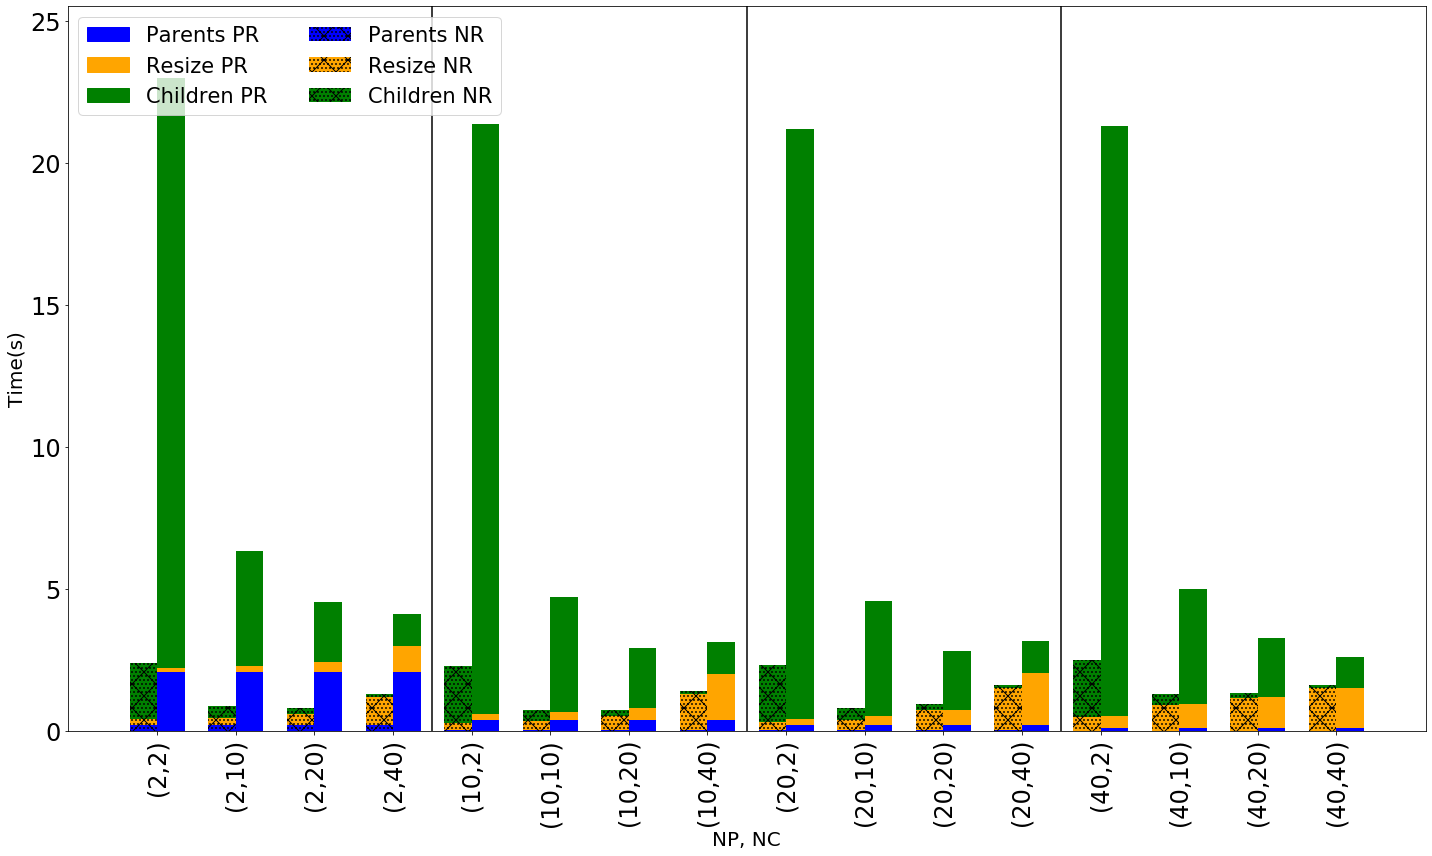

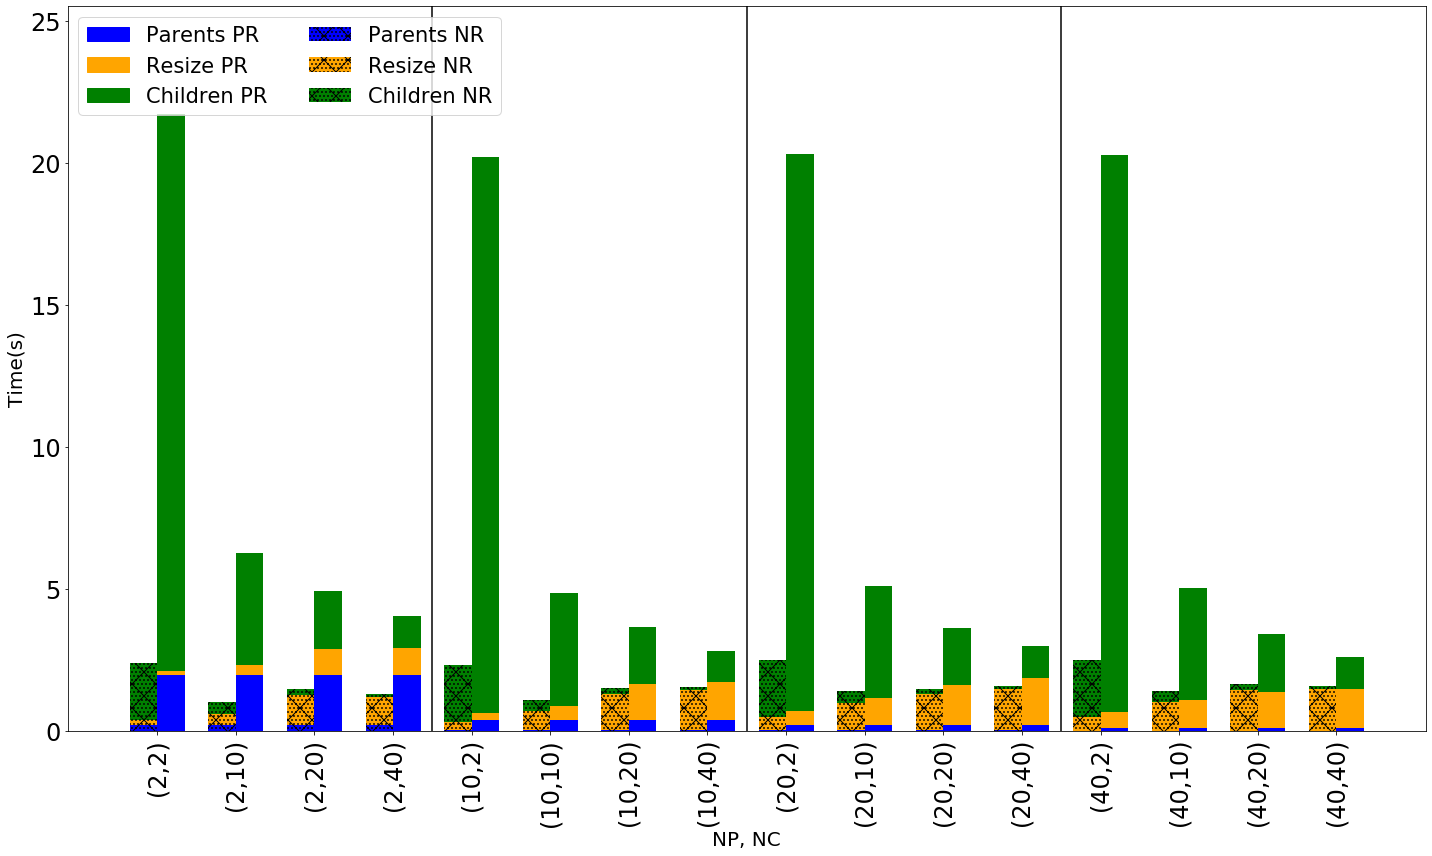

In [37]:
#TP_A_data=[[0.1997793257575758, 0.1997793257575758, 0.1997793257575758, 0.1997793257575758, 0.040469166666666695, 0.040469166666666695, 0.040469166666666695, 0.040469166666666695, 0.019951386363636366, 0.019951386363636366, 0.019951386363636366, 0.019951386363636366, 0.010227022727272729, 0.010227022727272729, 0.010227022727272729, 0.010227022727272729], [0.20020575000000002, 0.20020575000000002, 0.20020575000000002, 0.20020575000000002, 0.039894712121212116, 0.039894712121212116, 0.039894712121212116, 0.039894712121212116, 0.020662818181818185, 0.020662818181818185, 0.020662818181818185, 0.020662818181818185, 0.010635333333333332, 0.010635333333333332, 0.010635333333333332, 0.010635333333333332]]
#TH_A_data=[[1.9977932575757578, 0.40469166666666695, 0.19951386363636364, 0.10227022727272729, 1.9977932575757578, 0.40469166666666695, 0.19951386363636364, 0.10227022727272729, 1.9977932575757578, 0.40469166666666695, 0.19951386363636364, 0.10227022727272729, 1.9977932575757578, 0.40469166666666695, 0.19951386363636364, 0.10227022727272729], [2.0020575000000003, 0.39894712121212117, 0.20662818181818185, 0.10635333333333331, 2.0020575000000003, 0.39894712121212117, 0.20662818181818185, 0.10635333333333331, 2.0020575000000003, 0.39894712121212117, 0.20662818181818185, 0.10635333333333331, 2.0020575000000003, 0.39894712121212117, 0.20662818181818185, 0.10635333333333331]]
#TM_A_data=[[0.2083043333333333, 0.2661843333333333, 0.41778833333333326, 0.9868953333333335, 0.242685, 0.3060793333333333, 0.4986676666666667, 1.2530743333333334, 0.305179, 0.373607, 0.7375183333333334, 1.5113886666666667, 0.501651, 0.8987069999999999, 1.138518666666667, 1.5091376666666665], [0.205789, 0.4116923333333334, 1.0607546666666667, 0.9947066666666666, 0.27494700000000005, 0.669121, 1.2705783333333334, 1.3951336666666665, 0.4765406666666667, 0.9758123333333333, 1.267633, 1.4479673333333334, 0.4905743333333333, 1.0088953333333333, 1.4447113333333332, 1.4516683333333333]]


for dist in [1,2]:
    dist_index=dist-1
    f=plt.figure(figsize=(20, 12))
#for numP in values:

    x = np.arange(len(labelsP_J))

    width = 0.35
    sumaTP_TM = np.add(TP_data[dist_index], TM_data[dist_index]).tolist()
    sumaTP_TM_A = np.add(TP_A_data[dist_index], TM_A_data[dist_index]).tolist()

    ax=f.add_subplot(111)

    ax.bar(x+width/2, TP_data[dist_index], width, color='blue')
    ax.bar(x+width/2, TM_data[dist_index], width, bottom=TP_data[dist_index],color='orange')
    ax.bar(x+width/2, TH_data[dist_index], width, bottom=sumaTP_TM, color='green')

    ax.bar(x-width/2, TP_A_data[dist_index], width, hatch="\\/...", color='blue')
    ax.bar(x-width/2, TM_A_data[dist_index], width, bottom=TP_A_data[dist_index], hatch="\\/...", color='orange')
    ax.bar(x-width/2, TH_A_data[dist_index], width, bottom=sumaTP_TM_A, hatch="\\/...", color='green')

    ax.set_ylabel("Time(s)", fontsize=20)
    ax.set_xlabel("NP, NC", fontsize=20)
    plt.xticks(x, labelsP_J, rotation=90)

    blue_Spatch = mpatches.Patch(color='blue', label='Parents PR')
    orange_Spatch = mpatches.Patch(color='orange', label='Resize PR')
    green_Spatch = mpatches.Patch(color='green', label='Children PR')
    blue_Apatch = mpatches.Patch(hatch='\\/...', facecolor='blue', label='Parents NR')
    orange_Apatch = mpatches.Patch(hatch='\\/...', facecolor='orange', label='Resize NR')
    green_Apatch = mpatches.Patch(hatch='\\/...', facecolor='green', label='Children NR')


    handles=[blue_Spatch,orange_Spatch,green_Spatch,blue_Apatch,orange_Apatch,green_Apatch]

    plt.legend(handles=handles, loc='upper left', fontsize=21,ncol=2)
    
    ax.axvline((3.5), color='black')
    ax.axvline((7.5), color='black')
    ax.axvline((11.5), color='black')
    
    ax.tick_params(axis='both', which='major', labelsize=24)
    ax.tick_params(axis='both', which='minor', labelsize=22)
    plt.ylim((0, 25.5))
    #ax.axvline(4)
    
    f.tight_layout()
    f.savefig("Images/EX_Partitions_"+dist_names[dist]+".png", format="png")

In [11]:
def get_types_iker(checked_type='tc', used_direction='e', node_type="All", normality='m'):
    if checked_type=='te':
        var_aux='TE'
        tipo_fig="TE"
        grouped_aux=grouped_aggG2
    elif checked_type=='tc':
        var_aux='TC'
        tipo_fig="Mall"
        grouped_aux=grouped_aggM
    
    if node_type=='Intra':
        grouped_aux=grouped_aux.query('NP < 21 and NS < 21')
    elif node_type=='Inter':
        grouped_aux=grouped_aux.query('NP > 21 or NS > 21')

    if used_direction=='s':
        grouped_aux=grouped_aux.query('NP > NS')
        if node_type=='Intra':
            used_labels=labelsShrinkIntra
        elif node_type=='Inter':
            used_labels=labelsShrinkInter
        elif node_type=='All':
            used_labels=labelsShrink
        name_fig="Shrink"
        
        if normality=='r':
            handles=[OrSing_patch,OrPthMult_patch,OrPthSing_patch,MergeMult_patch,MergePthMult_patch]
        else:
            handles=[OrMult_patch,OrSing_patch,OrPthMult_patch,OrPthSing_patch,MergeMult_patch,MergePthMult_patch]
    elif used_direction=='e':
        grouped_aux=grouped_aux.query('NP < NS')
        if node_type=='Intra':
            used_labels=labelsExpandIntra
        elif node_type=='Inter':
            used_labels=labelsExpandInter
        elif node_type=='All':
            used_labels=labelsExpand
        name_fig="Expand"
        if normality=='r':
            handles=[OrSing_patch,OrPthMult_patch,OrPthSing_patch,MergeMult_patch,MergeSing_patch,MergePthMult_patch,MergePthSing_patch]
        else:
            handles=[OrMult_patch,OrSing_patch,OrPthMult_patch,OrPthSing_patch,MergeMult_patch,MergeSing_patch,MergePthMult_patch,MergePthSing_patch]
    title=tipo_fig+"_Spawn_"+node_type+"_"+name_fig+"_"+normality
    return var_aux, grouped_aux, handles, used_labels, title

In [12]:
def obtain_arrays_iker(grouped_aux, var_aux, used_direction='e', normality='m'):
    vOrMult = list(grouped_aux.query('Cst == 0 and Css == 0')[var_aux])
    vOrSingle = list(grouped_aux.query('Cst == 0 and Css == 1')[var_aux])
    vMergeMult = list(grouped_aux.query('Cst == 2 and Css == 0')[var_aux])
    vOrPthMult = list(grouped_aux.query('Cst == 1 and Css == 0')[var_aux])
    vOrPthSingle = list(grouped_aux.query('Cst == 1 and Css == 1')[var_aux])
    vMergePthMult = list(grouped_aux.query('Cst == 3 and Css == 0')[var_aux])
    h_line = None
    
    if used_direction=='e':
        vMergeSingle = list(grouped_aux.query('Cst == 2 and Css == 1')[var_aux])
        vMergePthSingle = list(grouped_aux.query('Cst == 3 and Css == 1')[var_aux])
    else:
        #FIXME Que tenga en cuenta TH al realizar shrink merge
        vMergePthMult = list(grouped_aux.query('Cst == 3 and Css == 0')[var_aux])
        vMergeSingle = None
        vMergePthSingle = None
    title_y = "Total time(s)"
        
    if normality == 'r':
        vOrSingle = np.subtract(vOrMult, vOrSingle)
        vOrPthMult = np.subtract(vOrMult, vOrPthMult)
        vOrPthSingle = np.subtract(vOrMult, vOrPthSingle)
        vMergeMult = np.subtract(vOrMult, vMergeMult)
        vMergePthMult = np.subtract(vOrMult, vMergePthMult)
        if used_direction=='e':
            vMergeSingle = np.subtract(vOrMult, vMergeSingle)
            vMergePthSingle = np.subtract(vOrMult, vMergePthSingle)
        vOrMult = None
        h_line = 0
        title_y = "Saved time(s)"
    elif normality == 'n':
        vOrSingle = np.divide(vOrSingle, vOrMult)
        vOrPthMult = np.divide(vOrPthMult, vOrMult)
        vOrPthSingle = np.divide(vOrPthSingle, vOrMult)
        vMergeMult = np.divide(vMergeMult, vOrMult)
        vMergePthMult = np.divide(vMergePthMult, vOrMult)
        if used_direction=='e':
            vMergeSingle = np.divide(vMergeSingle, vOrMult)
            vMergePthSingle = np.divide(vMergePthSingle, vOrMult)
        vOrMult = np.divide(vOrMult, vOrMult)
        h_line = 1
        title_y = "Relation Config time / Baseline Time"
    
    data_array=[vOrMult,vOrSingle,vOrPthMult,vOrPthSingle,vMergeMult,vMergeSingle,vMergePthMult,vMergePthSingle]
    v_lines=[]
    value_aux = 0.4
    if used_direction == 'e':
        value_aux = 0.5
    for i in range(0, len(vOrSingle)-1):
        v_lines.append(value_aux + i)
    return data_array, title_y, v_lines, h_line



In [13]:
def legend_loc_iker(data_array, len_x, ylim_zero):
    
    max_value = np.nanmax([x for x in data_array if x is not None]) # Los valores None es necesario evitarlos
    min_value = np.nanmin([x for x in data_array if x is not None]) # Los valores None es necesario evitarlos
    if(ylim_zero):
        min_value = 0
    middle_value = (max_value + min_value) / 2
    offset = (max_value - min_value) * 0.1
    
    def array_check_loc(ini, end):
        up = True
        lower = True
        for i in range(ini, end):
            for j in range(len(data_array)):
                if not (data_array[j] is None):
                    if data_array[j][i] > (middle_value + offset):
                        up = False
                    elif data_array[j][i] < (middle_value - offset):
                        lower = False
                    if not up and not lower:
                        break
            else:
                continue # Only executed if inner loop did NOT break
            break # Only executed if inner loop did break
        return up,lower
    
    up_left, lower_left = array_check_loc(0, math.floor(len_x/2))
    up_right, lower_right = array_check_loc(0, math.floor(len_x/2))

    legend_loc = 'best'
    if up_left:
        legend_loc = 'upper left'
    elif up_right:
        legend_loc = 'upper right'
    elif lower_left:
        legend_loc = 'lower left'
    elif lower_right:
        lower_right = 'lower right'

    return legend_loc
        

In [14]:
def graphic_iker(data_array, title="None", title_y="None", title_x="None", handles=None, used_labels=None, v_lines=None, h_line=None, ylim_zero=True):
    f=plt.figure(figsize=(30, 12))
    ax=f.add_subplot(111)
    x = np.arange(len(used_labels))
    width = 0.45/4
    
    legend_loc = legend_loc_iker(data_array, len(used_labels), ylim_zero)

    if not (data_array[0] is None):
        ax.bar(x-width*3.5, data_array[0], width, color='green')
    ax.bar(x-width*2.5, data_array[1], width, hatch="", color='springgreen')
    ax.bar(x-width*1.5, data_array[2], width, hatch="//", color='blue')
    ax.bar(x-width*0.5, data_array[3], width, hatch="\\",color='darkblue')

    ax.bar(x+width*0.5, data_array[4], width, hatch="||", color='red')
    if not (data_array[5] is None):
        ax.bar(x+width*1.5, data_array[5], width, hatch="...", color='darkred')
        ax.bar(x+width*2.5, data_array[6], width, hatch="xx", color='yellow')
    else:
        ax.bar(x+width*1.5, data_array[6], width, hatch="xx", color='yellow')
    if not (data_array[7] is None):
        ax.bar(x+width*3.5, data_array[7], width, hatch="++",color='olive')

    ax.axhline((0), color='black', linestyle='dashed')
    ax.set_ylabel(title_y, fontsize=30)
    ax.set_xlabel(title_x, fontsize=28)
    plt.xticks(x, used_labels, rotation=90)
    plt.legend(handles=handles, loc=legend_loc, fontsize=26,ncol=2,framealpha=1)
    
    if not ylim_zero: # Modifica los limites del eje y. No es buena practica que no aparezca el 0
        max_value = np.nanmax([x for x in data_array if x is not None]) # Los valores None es necesario evitarlos
        max_value += max_value * 0.1
        min_value = np.nanmin([x for x in data_array if x is not None]) # Los valores None es necesario evitarlos
        min_value -= min_value * 0.1
        if min_value < 0.1:
            min_value = 0
        plt.ylim((min_value, max_value))
    
    for line in v_lines:
        ax.axvline((line), color='black')
    if h_line != None:
        ax.axhline((h_line), color='black')
    
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.tick_params(axis='both', which='minor', labelsize=28)
    
    f.tight_layout()
    f.savefig("Images/Spawn/"+title+".png", format="png")

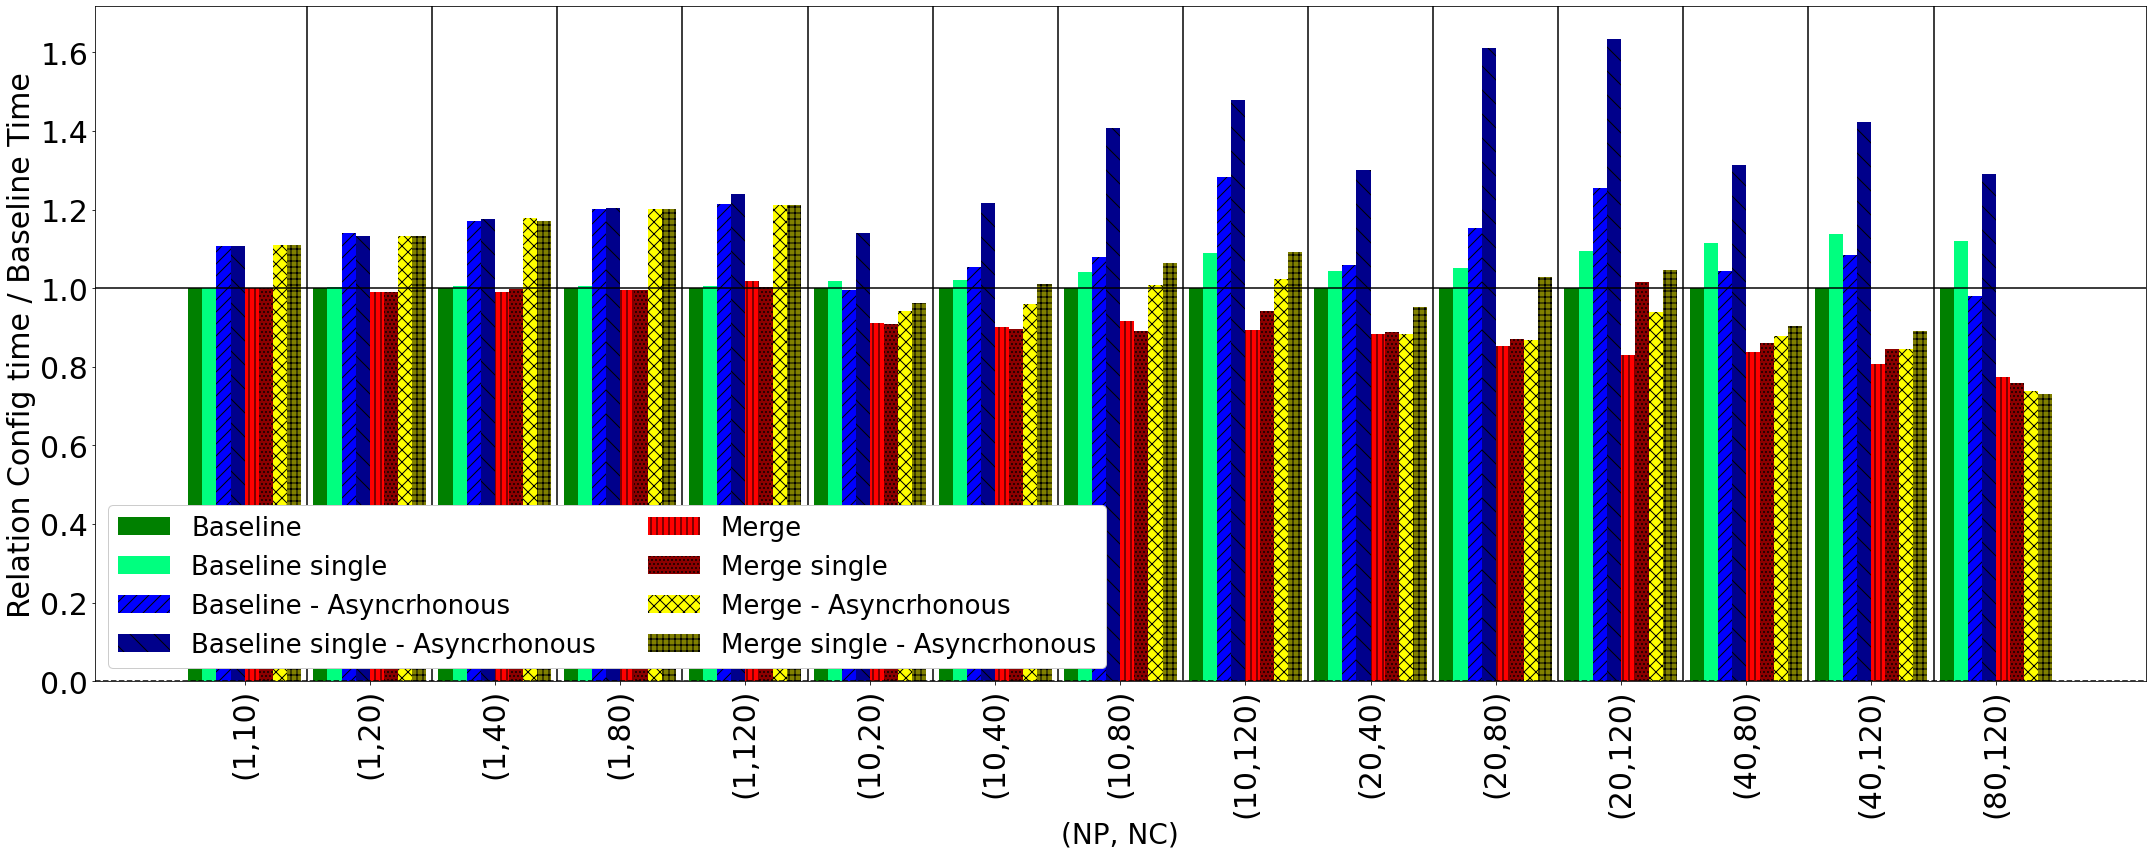

In [15]:
checked_type='te' # Valores 'te' y 'tc'
used_direction='e' # Valores 's' y 'e'
node_type='All' # Valores 'Intra', 'Inter', 'All'
normality='n'
#Values 'n' (normalizar), 'l' (logaritmico), 'm' (sin modificaciones), 'r' (Comparar respecto al primero)

ylim_zero = True

var_aux, grouped_aux, handles, used_labels, title = get_types_iker(checked_type, used_direction, node_type, normality)
array_aux, title_y, v_lines, h_line = obtain_arrays_iker(grouped_aux, var_aux, used_direction, normality)
graphic_iker(array_aux, title, title_y, "(NP, NC)", handles, used_labels, v_lines, ylim_zero)

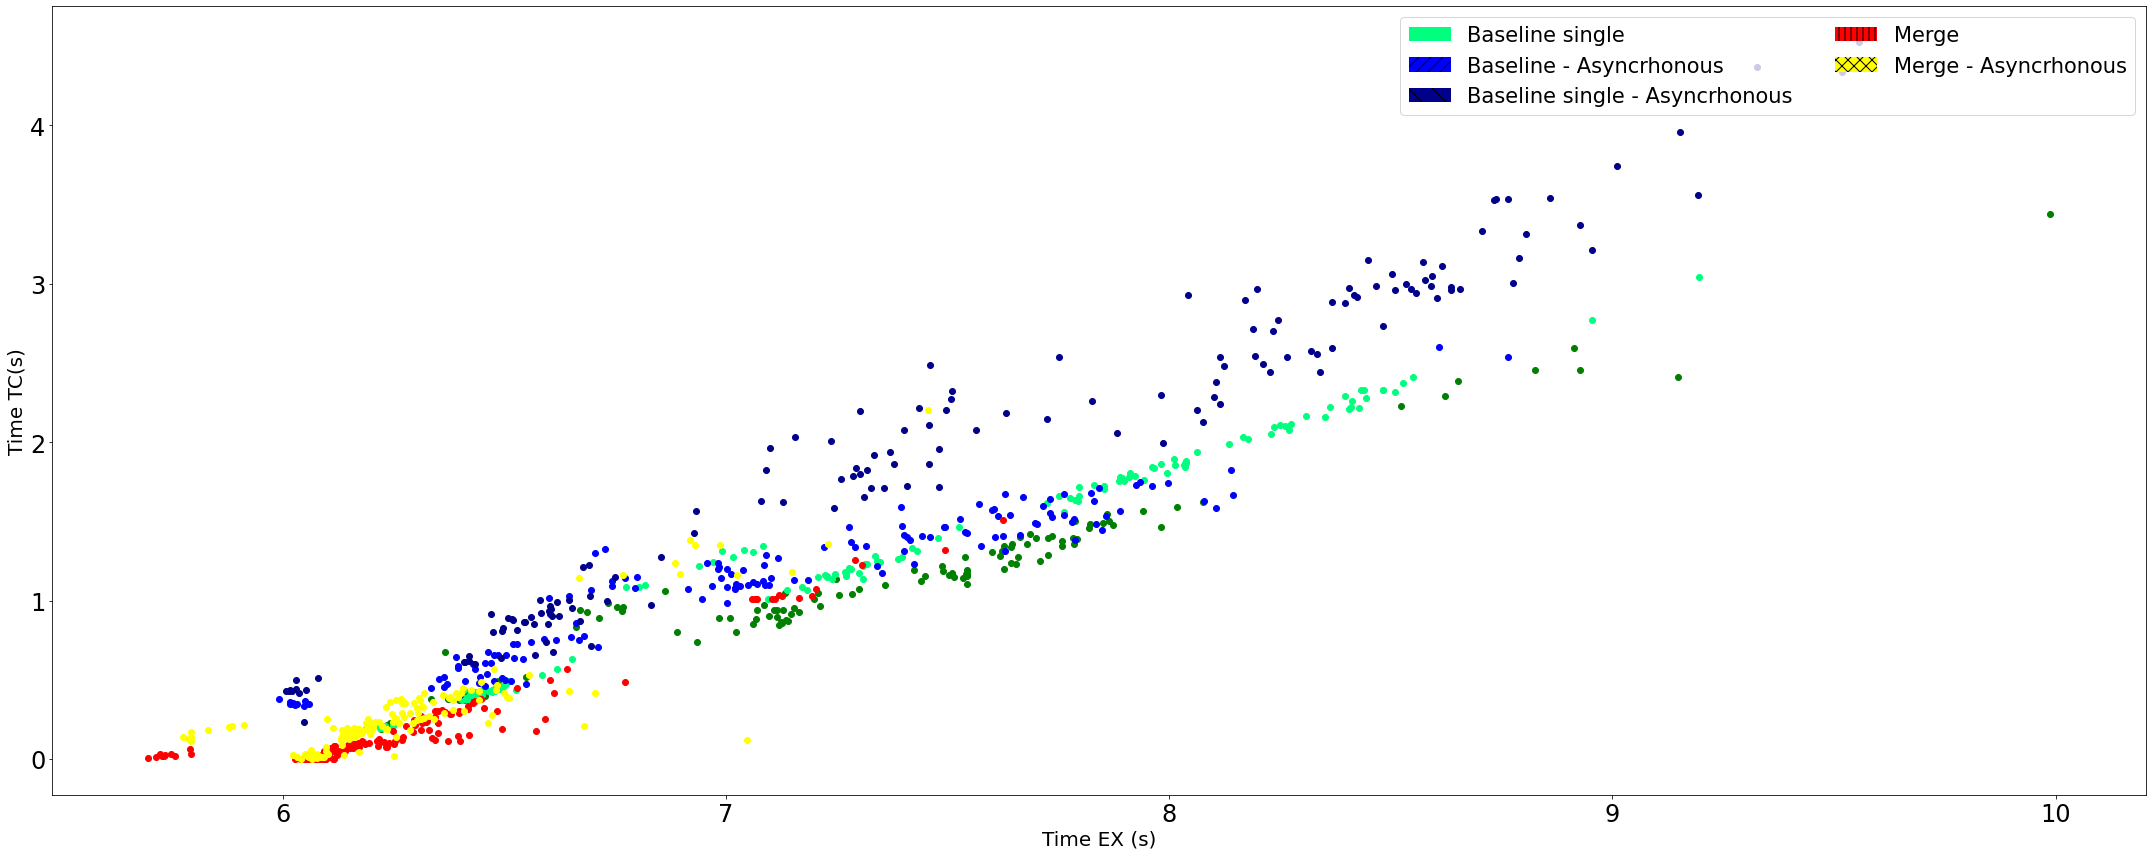

In [48]:
used_direction='s'
    
if used_direction=='s':
    dfM_aux=dfM.query('NP > NS')
    dfG_aux=dfG.query('NP > NS')
    used_labels=labelsShrink
    name_fig="Shrink"
    handles=[OrSing_patch,OrPthMult_patch,OrPthSing_patch,MergeMult_patch,MergePthMult_patch]
elif used_direction=='e':
    dfM_aux=dfM.query('NP < NS')
    dfG_aux=dfG.query('NP < NS')
    used_labels=labelsExpand
    name_fig="Expand"
    handles=[OrSing_patch,OrPthMult_patch,OrPthSing_patch,MergeMult_patch,MergeSing_patch,MergePthMult_patch,MergePthSing_patch]
# < Expand
# > Shrink

vOrMult = list(dfG_aux.query('Cst == 0 and Css == 0')['TE'])
vOrSingle = list(dfG_aux.query('Cst == 0 and Css == 1')['TE'])
vOrPthMult = list(dfG_aux.query('Cst == 1 and Css == 0')['TE'])
vOrPthSingle = list(dfG_aux.query('Cst == 1 and Css == 1')['TE'])

vMergeMult = list(dfG_aux.query('Cst == 2 and Css == 0')['TE'])
vMergeSingle = list(dfG_aux.query('Cst == 2 and Css == 1')['TE'])
vMergePthMult = list(dfG_aux.query('Cst == 3 and Css == 0')['TE'])
vMergePthSingle = list(dfG_aux.query('Cst == 3 and Css == 1')['TE'])

vOrMult2 = list(dfM_aux.query('Cst == 0 and Css == 0')['TC'])
vOrSingle2 = list(dfM_aux.query('Cst == 0 and Css == 1')['TC'])
vOrPthMult2 = list(dfM_aux.query('Cst == 1 and Css == 0')['TC'])
vOrPthSingle2 = list(dfM_aux.query('Cst == 1 and Css == 1')['TC'])

vMergeMult2 = list(dfM_aux.query('Cst == 2 and Css == 0')['TC'])
vMergeSingle2 = list(dfM_aux.query('Cst == 2 and Css == 1')['TC'])
vMergePthMult2 = list(dfM_aux.query('Cst == 3 and Css == 0')['TC'])
vMergePthSingle2 = list(dfM_aux.query('Cst == 3 and Css == 1')['TC'])

f=plt.figure(figsize=(30, 12))
ax=f.add_subplot(111)

ax.scatter(vOrMult,vOrMult2, color='green')
ax.scatter(vOrSingle,vOrSingle2,  color='springgreen')
ax.scatter(vOrPthMult,vOrPthMult2, color='blue')
ax.scatter(vOrPthSingle,vOrPthSingle2,color='darkblue')

ax.scatter(vMergeMult,vMergeMult2, color='red')
if used_direction=='e':
    ax.scatter(vMergeSingle,vMergeSingle2,color='darkred')
ax.scatter(vMergePthMult,vMergePthMult2, color='yellow')
if used_direction=='e':
    ax.scatter(vMergePthSingle,vMergePthSingle2,color='olive')

ax.set_ylabel("Time TC(s)", fontsize=20)
ax.set_xlabel("Time EX (s)", fontsize=20)
#plt.xticks(x, used_labels, rotation=90)
plt.legend(handles=handles, loc='upper right', fontsize=21,ncol=2)
    
ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=22)
    
f.tight_layout()
f.savefig("Images/Spawn/Dispersion_Spawn_"+name_fig+".png", format="png")

In [ ]:
valores1 = [0]*10
valores2 = [0.2]*10
valores3 = [0.4]*10
valores4 = [0.6]*10
valores5 = [0.8]*10
valores6 = [1]*10
valores7 = [1.2]*10
valores8 = [1.4]*10

for np_aux in processes:
    for ns_aux in processes:
        if np_aux != ns_aux:
            if np_aux > ns_aux:
                used_labels=labelsShrink
                name_fig="Shrink"
                handles=[OrMult_patch,OrSing_patch,OrPthMult_patch,OrPthSing_patch,MergeMult_patch,MergePthMult_patch]
            else:
                used_labels=labelsExpand
                name_fig="Expand"
                handles=[OrMult_patch,OrSing_patch,OrPthMult_patch,OrPthSing_patch,MergeMult_patch,MergeSing_patch,MergePthMult_patch,MergePthSing_patch]
                
            dfM_aux = dfM.query('NP == @np_aux and NS == @ns_aux')
            vOrMult2 = list(dfM_aux.query('Cst == 0 and Css == 0')['TC'])
            vOrSingle2 = list(dfM_aux.query('Cst == 0 and Css == 1')['TC'])
            vOrPthMult2 = list(dfM_aux.query('Cst == 1 and Css == 0')['TC'])
            vOrPthSingle2 = list(dfM_aux.query('Cst == 1 and Css == 1')['TC'])

            vMergeMult2 = list(dfM_aux.query('Cst == 2 and Css == 0')['TC'])
            vMergeSingle2 = list(dfM_aux.query('Cst == 2 and Css == 1')['TC'])
            vMergePthMult2 = list(dfM_aux.query('Cst == 3 and Css == 0')['TC'])
            vMergePthSingle2 = list(dfM_aux.query('Cst == 3 and Css == 1')['TC'])

            f=plt.figure(figsize=(16, 8))
            ax=f.add_subplot(111)

            ax.scatter(vOrMult2,valores1, color='green')
            ax.scatter(vOrSingle2,valores2,  color='springgreen')
            ax.scatter(vOrPthMult2,valores3, color='blue')
            ax.scatter(vOrPthSingle2,valores4,color='darkblue')

            ax.scatter(vMergeMult2,valores5, color='red')
            if np_aux < ns_aux:
                ax.scatter(vMergeSingle2,valores6,color='darkred')
            ax.scatter(vMergePthMult2,valores7, color='yellow')
            if np_aux < ns_aux:
                ax.scatter(vMergePthSingle2,valores8,color='olive')

            ax.set_xlabel("Time TC(s)", fontsize=16)
            ax.set_ylabel("-", fontsize=16)
#plt.xticks(x, used_labels, rotation=90)
            plt.legend(handles=handles, loc='upper right', fontsize=14,ncol=2)
    
            ax.tick_params(axis='both', which='major', labelsize=20)
            ax.tick_params(axis='both', which='minor', labelsize=18)
    
            f.tight_layout()
            f.savefig("Images/Spawn/Dispersion/Dispersion_Spawn_"+name_fig+"_"+str(np_aux)+"_"+str(ns_aux)+".png", format="png")

In [ ]:
used_direction='e'
test_parameter='TA'
#TS es merge y TA connect para tests solo spawn
    
if used_direction=='s':
    dfM_aux=dfM.query('NP > NS')
    used_labels=labelsShrink
    name_fig="Shrink"
    handles=[OrSing_patch,OrPthMult_patch,OrPthSing_patch,MergeMult_patch,MergePthMult_patch]
elif used_direction=='e':
    dfM_aux=dfM.query('NP < NS')
    used_labels=labelsExpand
    name_fig="Expand"
    handles=[OrSing_patch,OrPthMult_patch,OrPthSing_patch,MergeMult_patch,MergeSing_patch,MergePthMult_patch,MergePthSing_patch]
# < Expand
# > Shrink

dfM_aux = dfM_aux.copy()
#dfM_aux['NTotal'] = dfM_aux['NP'] + dfM_aux['NS']
dfM_aux['NTotal'] = dfM_aux['NS']

#x = np.arange(len(used_labels))
for cst_aux in [0,1,2,3]:
    for css_aux in [0,1]:
        f=plt.figure(figsize=(20, 12))
        ax=f.add_subplot(111)
        
        #sns.boxplot(y=test_parameter, x="NS", hue="NP", data = dfM_aux[(dfM_aux.Cst == cst_aux)][(dfM_aux.Css == css_aux)], orient="v", ax=ax)
        sns.boxplot(y=test_parameter, x="NTotal", data = dfM_aux[(dfM_aux.Cst == cst_aux)][(dfM_aux.Css == css_aux)], orient="v", ax=ax)
        
        # Anyade en el plot el numero de iteraciones - Por hacer TODO
        # https://stackoverflow.com/questions/45475962/labeling-boxplot-with-median-values
        #medians_aux = dfM[(dfM.Cst == cst_aux)][(dfM.Css == css_aux)].groupby(['NS','NP'])['TC'].median()
        #m1 = dfM[(dfM.Cst == cst_aux)][(dfM.Css == css_aux)].groupby(['NS','NP'])['TC'].median().values
        #mL1 = [str(np.ceil(s)) for s in m1]

        #ind = 0
        #for tick in range(len(ax.get_xticklabels())):
        #    ax.text(tick-.2, m1[ind+1]+1, mL1[ind+1],  horizontalalignment='center',  color='w', weight='semibold')
        #    ax.text(tick+.2, m1[ind]+1, mL1[ind], horizontalalignment='center', color='w', weight='semibold')
        #    ind += 2 
        
        ax.set_ylabel("Time TC(s)", fontsize=20)
        ax.set_xlabel("NC", fontsize=20)
        plt.legend(loc='upper left', fontsize=21, title = "NP")
        ax.tick_params(axis='both', which='major', labelsize=24)
        ax.tick_params(axis='both', which='minor', labelsize=22)
        
        ax.axvline((.5), color='black')
        ax.axvline((1.5), color='black')
        ax.axvline((2.5), color='black')
        ax.axvline((3.5), color='black')
        ax.axvline((4.5), color='black')
        
        f.tight_layout()
        f.savefig("Images/Spawn/Boxplot_"+name_fig+"_"+test_parameter+"_"+labelsMethods[cst_aux*2 + css_aux]+".png", format="png")

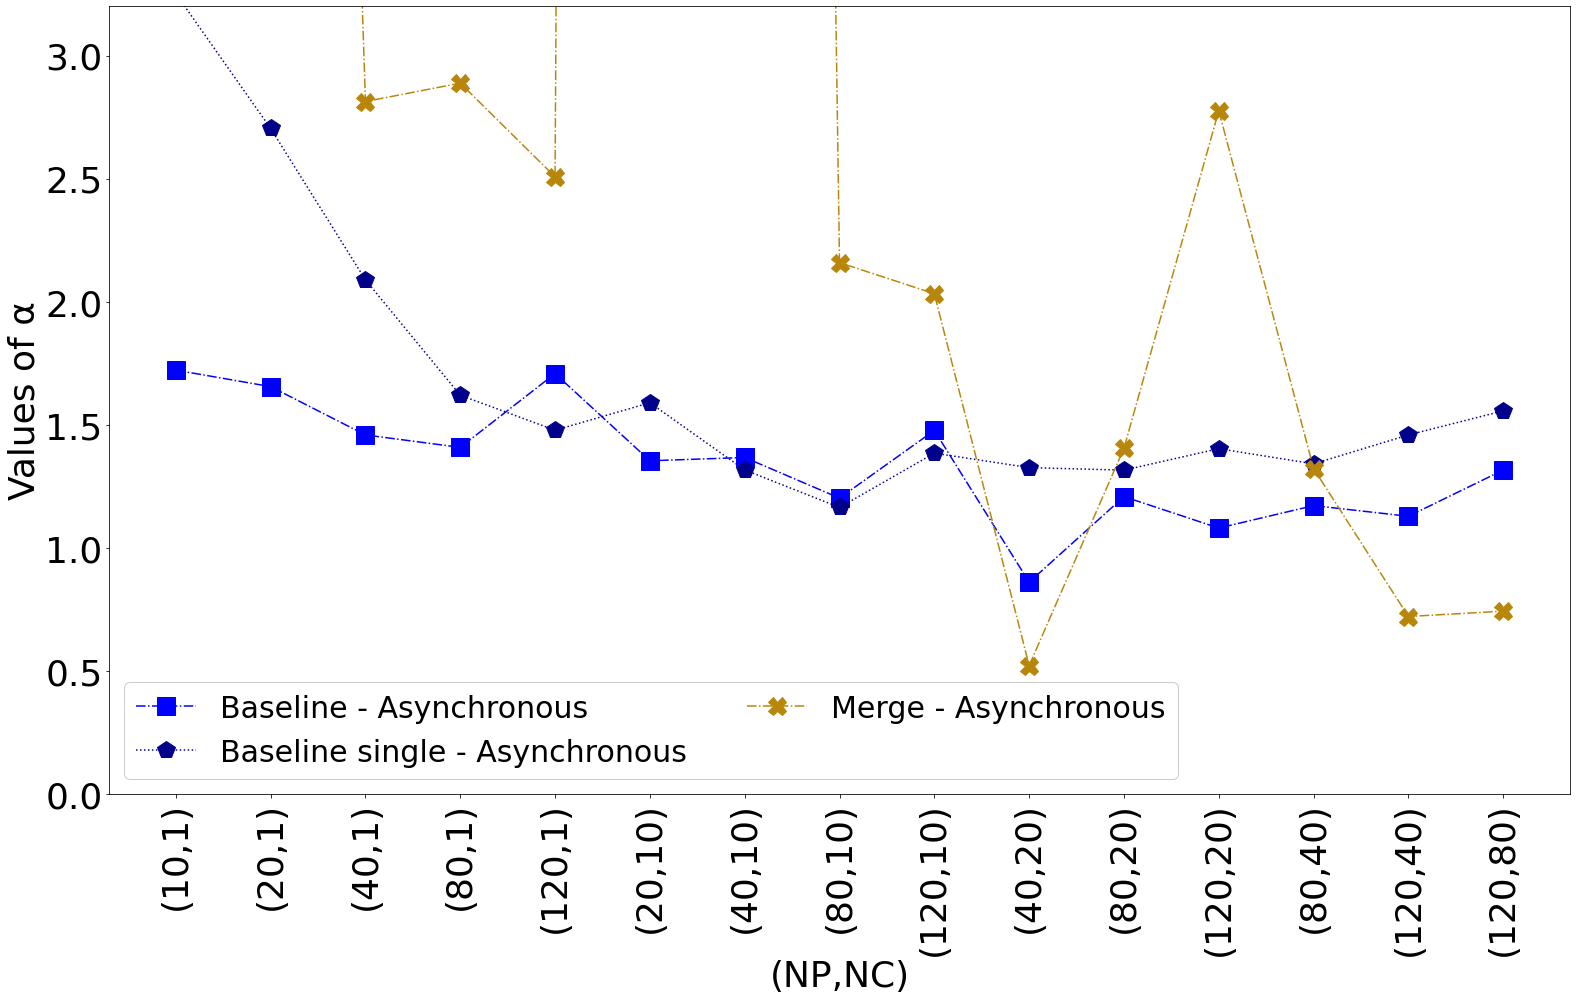

In [77]:
used_direction='s'
test_parameter='alpha' #Valores son "alpha" o "omega"

if test_parameter == 'alpha':
    name_fig="Alpha_"
    real_parameter='Alpha_A'
    name_legend = "Values of α"
elif test_parameter == 'omega':
    name_fig="Omega_"
    real_parameter='Omega_A'
    name_legend = "Values of ω"
df_aux=grouped_aggM
if used_direction=='s':
    df_aux=df_aux.query('NP > NS')
    used_labels=labelsShrinkOrdered
    name_fig= name_fig+"Shrink"
elif used_direction=='e':
    df_aux=df_aux.query('NP < NS')
    used_labels=labelsExpand
    name_fig= name_fig+"Expand"
elif used_direction=='a':
    df_aux=df_aux
    used_labels=labels
    name_fig= name_fig+"All"    

x = np.arange(len(used_labels))

f=plt.figure(figsize=(22, 14))
ax=f.add_subplot(111)
ax.set_xlabel("(NP,NC)", fontsize=36)
ax.set_ylabel(name_legend, fontsize=36)
plt.xticks(x, used_labels,rotation=90)
ax.tick_params(axis='both', which='major', labelsize=36)
ax.tick_params(axis='both', which='minor', labelsize=36)

for cst_aux in [1,3]:
    df_aux2 = df_aux.query('Cst == @cst_aux')
    for css_aux in [0,1]:
        if cst_aux == 3 and css_aux == 1 and used_direction == 's':
            continue
        array_aux = df_aux2.query('Css == @css_aux')
        if used_direction=='s':
            array_aux = array_aux.sort_values(by=['NS'])
        array_aux = array_aux[real_parameter].values
        style_aux = cst_aux*2 + css_aux
        ax.plot(x, array_aux, color=colors_spawn[style_aux], linestyle=linestyle_spawn[style_aux%4], \
                marker=markers_spawn[style_aux], markersize=18, label=labelsMethods[style_aux])
        
ax.set_ylim(0,3.2)
plt.legend(loc='best', fontsize=30,ncol=2,framealpha=1)
        
f.tight_layout()
f.savefig("Images/Spawn/LinePlot_"+name_fig+".png", format="png")

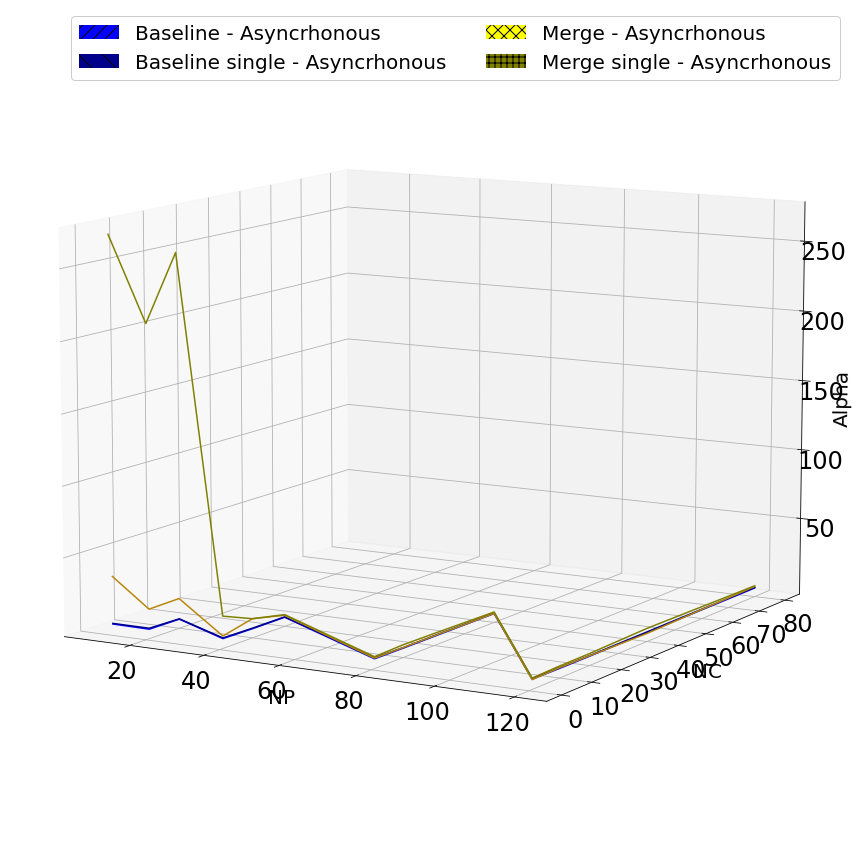

In [104]:
used_direction='s'
test_parameter='alpha' #Valores son "alpha" o "omega"
    
if used_direction=='s':
    df_aux=grouped_aggM.query('NP > NS')
    used_labels=labelsShrink
    name_fig="Shrink"
    np_aux = [10, 20,20, 40,40,40, 80,80,80,80, 120,120,120,120,120]
    nc_aux = [1,  1,10,  1,10,20,  1,10,20,40,  1,10,20,40,80]
elif used_direction=='e':
    df_aux=grouped_aggM.query('NP < NS')
    used_labels=labelsExpand
    name_fig="Expand"
    np_aux = [1,1,1,1,1,        10,10,10,10,  20,20,20,  40,40,  80 ]
    nc_aux = [10,20,40,80,120,  20,40,80,120, 40,80,120, 80,120, 120]
elif used_direction=='a':
    df_aux=grouped_aggM
    used_labels=labels
    name_fig="All"
    np_aux = [1,1,1,1,1,        10,10,10,10,10, 20,20,20,20,20, 40,40,40,40,40, 80,80,80,80,80, 120,120,120,120,120]
    nc_aux = [10,20,40,80,120,  1,20,40,80,120, 1,10,40,80,120, 1,10,20,80,120, 1,10,20,40,120, 1,10,20,40,80]
    
x = np.arange(len(used_labels))
handles = []

f=plt.figure(figsize=(20, 12))
#ax=f.add_subplot(111)
ax = plt.axes(projection='3d')
ax.azim = -60
ax.dist = 10
ax.elev = 10
ax.set_xlabel("NP", fontsize=20)
ax.set_ylabel("NC", fontsize=20)
ax.set_zlabel("Alpha", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=22)

for cst_aux in [1,3]:
    df_aux2 = df_aux.query('Cst == @cst_aux')
    for css_aux in [0,1]:
        array_aux = df_aux2.query('Css == @css_aux')['alpha'].values
        ax.plot3D(np_aux, nc_aux, array_aux, colors_spawn[cst_aux*2 + css_aux])
      
        handles.append(handles_spawn[cst_aux*2 + css_aux])
        
#ax.set_zlim(0,4)
plt.legend(handles=handles, loc='best', fontsize=20,ncol=2,framealpha=1)
        
f.tight_layout()
f.savefig("Images/Spawn/3dPlot_"+name_fig+'_'+test_parameter+".png", format="png")

In [29]:
def check_normality(df, tipo):
    normality=[True] * (len(processes) * (len(processes)-1))
    total=0
    i=-1
    #Comprobar para cada configuración si se sigue una distribución normal/gaussiana
    for np_aux in processes:
        for ns_aux in processes:
            if np_aux != ns_aux:
                i+=1
                for cst_aux in [0,1,2,3]:
                    for css_aux in [0,1]:
                        df_aux = df.query('NP == @np_aux and NS == @ns_aux and Cst == @cst_aux and Css == @css_aux')
                        dataList = list(df_aux[tipo])
                        st,p = stats.shapiro(dataList) # Tendrían que ser al menos 20 datos y menos de 50
                        if p < p_value:
                            normality[i]=False
                            total+=1
            
    
    print("Se sigue una distribución guassiana: " + str(normality) + "\nUn total de: " + str(total) + " no siguen una gaussiana")
    return normality

In [30]:
def compute_global_stat_difference(dataLists, parametric):
    if parametric:
        st,p=stats.f_oneway(dataLists[0],dataLists[1],dataLists[2],dataLists[3],dataLists[4],dataLists[5],dataLists[6],dataLists[7])
    else:
        st,p=stats.kruskal(dataLists[0],dataLists[1],dataLists[2],dataLists[3],dataLists[4],dataLists[5],dataLists[6],dataLists[7])
    if p > p_value: # Si son iguales, no hay que hacer nada más
        return False
    return True

In [31]:
def compute_global_posthoc(dataLists, parametric):
    data_stats=[]
    ini=0
    end=len(labelsMethods)
    if parametric:
        df_aux = sp.posthoc_ttest(dataLists)
        df_Res = df_aux.copy()
        for i in range(ini,end):
            data_stats.append(np.mean(dataLists[i]))
            for j in range(ini,end):
                if df_Res.iat[i,j] < p_value: # Medias diferentes
                    df_Res.iat[i, j] = True
                else:
                    df_Res.iat[i, j] = False
    else:
        df_aux = sp.posthoc_conover(dataLists)
        df_Res = df_aux.copy()
        for i in range(ini,end):
            data_stats.append(np.median(dataLists[i]))
            for j in range(ini,end):
                if df_Res.iat[i,j] < p_value: # Medianas diferentes
                    df_Res.iat[i, j] = True
                else:
                    df_Res.iat[i, j] = False
    #print(df_Res)
    #print(df_aux)
    #print(data_stats)
    return df_Res, data_stats

In [32]:
# Aquellos grupos que tengán valores por encima del límite no se considerarán
# Con sumar a si mismos su valor actual estarán fuera
def check_groups_boundaries(data_stats, np_aux, ns_aux, tc_boundary):
    index_aux = 0
    for cst_aux in [0,2]: # Primero los grupos síncronos
        for css_aux in [0,1]:
            if cst_aux == 2 and css_aux == 1 and np_aux > ns_aux: # Arreglo para coger bien el tiempo en Merge Single Shrink
                index_aux = 1
            tc_val = grouped_aggM.loc[('2,2',0, cst_aux, css_aux - index_aux, np_aux,ns_aux), 'TC_A']
            if tc_val > tc_boundary:
                data_stats[cst_aux*2 + css_aux]+=data_stats[cst_aux*2 + css_aux]
    index_aux = 0
    for cst_aux in [1,3]: # Segundo se comprueban los asíncronos
        for css_aux in [0,1]:
            if cst_aux == 3 and css_aux == 1 and np_aux > ns_aux: # Arreglo para coger bien el tiempo en Merge Single Shrink
                index_aux = 1
            tc_val = grouped_aggM.loc[('2,2',0, cst_aux, css_aux - index_aux, np_aux,ns_aux), 'TH']
            if tc_val > tc_boundary:
                data_stats[cst_aux*2 + css_aux]+=data_stats[cst_aux*2 + css_aux]

In [33]:
def get_stat_differences(df_Res, data_stats, np_aux, ns_aux, shrink, parametric):
    best = 0
    otherBest=[]
    
    # TODO Descomentar tras anyadir RMS perspective en results_with_st
    #if rms_boundary != 0: # Si se usa perspectiva de RMS, se desconsideran valores muy altos
    #    check_groups_boundaries(data_stats, np_aux, ns_aux, tc_boundary) 
        
    indexes = np.argsort(data_stats)
    best = -1
    i = 0
    while best == -1:
        index = indexes[i]
        if not (shrink and (index == 5 or index == 7)): # Las opciones Merge single(5) y Merge single - Pthreads(7) no se utilizan al reducir
            #if rms_boundary == 0 or data_stats[index] <= tc_boundary:
            best = index
        i+=1
    otherBest=[]
    for index in range(len(labelsMethods)): # Para cada metodo exceptuando best
        if not (shrink and (index == 5 or index == 7)): # Las opciones Merge single(5) y Merge single - Pthreads(7) no se utilizan al reducir
            if index != best and not df_Res.iat[best,index]: #Medias/Medianas iguales
                #if data_stats[index] <= tc_boundary:
                otherBest.append(index)
    stringV=""
    for i in otherBest:
        stringV+=labelsMethods[i]+", "
    print("Redimensión " + str(np_aux) + "/" + str(ns_aux) +" "+ str(parametric)+" Mejores: " + labelsMethods[best]+", " + stringV)
    otherBest.insert(0,best)
    
    return otherBest

In [34]:
def get_perc_differences(dataLists, np_aux, ns_aux, shrink, rms_boundary, tc_boundary):
    data_stats = []
    ini=0
    end=len(labelsMethods)
    for i in range(ini,end):
        data_stats.append(np.median(dataLists[i]))
        
    if rms_boundary != 0: # Si se usa perspectiva de RMS, se desconsideran valores muy altos
        check_groups_boundaries(data_stats, np_aux, ns_aux, tc_boundary) 
    indexes = np.argsort(data_stats)
    
    best = -1
    bestMax = -1
    otherBest=[]
    for index in indexes: # Para cada metodo -- Empezando por el más bajo en media/mediana
        if shrink and (index == 5 or index == 7): # Las opciones Merge single(5) y Merge single - Pthreads(7) no se utilizan al reducir
            continue
        
        if best == -1:
            best = index
            bestMax = data_stats[best] * 0.05 + data_stats[best]
        elif data_stats[index] <= bestMax: # Medias/Medianas diferentes && Media/Medianas i < Media/Mediana best
            otherBest.append(index)
                
        
    stringV=""
    for i in otherBest:
        stringV+=labelsMethods[i]+", "
    print("Redimensión " + str(np_aux) + "/" + str(ns_aux)+" Mejores: " + labelsMethods[best]+", " + stringV)
    otherBest.insert(0,best)
    
    return otherBest

In [35]:
#Obtiene 
def check_groups_stats(dataLists, np_aux, ns_aux, shrink, parametric):
    global_difference=compute_global_stat_difference(dataLists, parametric)
    if not global_difference:
        print("Configuración: " + str(np_aux) + "/" + str(ns_aux) + " tiene valores iguales")
        return
    
    df_Res,data_stats=compute_global_posthoc(dataLists,parametric)
    return get_stat_differences(df_Res, data_stats, np_aux, ns_aux, shrink, parametric)
    

In [36]:
def results_with_st(tipo, data_aux):
    normality=check_normality(data_aux,tipo)
    if False in normality:
        normality = False
    else:
        normality = True
    
    
    results = []
    shrink = False
    for np_aux in processes:
        for ns_aux in processes:
            if np_aux != ns_aux:
                dataSet = data_aux.query('NP == @np_aux and NS == @ns_aux')
                dataLists=[]
                if np_aux > ns_aux:
                    shrink = True
                else:
                    shrink = False
                #normality=True
                for cst_aux in [0,1,2,3]:
                    for css_aux in [0,1]:
                        dataSet_aux = dataSet.query('Cst == @cst_aux and Css == @css_aux')
                        lista_aux = list(dataSet_aux[tipo])
                        dataLists.append(lista_aux)
                        #Si permito el shaphiro, acabare comparando manzanas y naranjas
                        # si hay distribuciones normales y no normales
                        #st,p = stats.shapiro(lista_aux) # Tendrían que ser al menos 20 datos y menos de 50
                        #if p < p_value:
                        #normality=False

                aux_data = check_groups_stats(dataLists, np_aux, ns_aux, shrink, normality)
                results.append(aux_data)
    return results

In [37]:
def results_with_perc(tipo, data_aux, rms_boundary=0):
    results = []
    shrink = False
    for np_aux in processes:
        for ns_aux in processes:
            if np_aux != ns_aux:
                dataSet = data_aux.query('NP == @np_aux and NS == @ns_aux')
                dataLists=[]
                if np_aux > ns_aux:
                    shrink = True
                else:
                    shrink = False
                
                tc_boundary = dfM.query('NP == @np_aux and NS == @ns_aux')['TC'].max()
                if rms_boundary == 0:
                    for cst_aux in [0,1,2,3]:
                        for css_aux in [0,1]:
                            dataSet_aux = dataSet.query('Cst == @cst_aux and Css == @css_aux')
                            lista_aux = list(dataSet_aux[tipo])
                            dataLists.append(lista_aux)
                else:
                    boundaries = []
                    for cst_aux in [0,1,2,3]:
                        for css_aux in [0,1]:
                            dataSet_aux = dataSet.query('Cst == @cst_aux and Css == @css_aux')
                            lista_aux = list(dataSet_aux[tipo])
                            dataLists.append(lista_aux)
                            
                            if cst_aux == 0 or cst_aux == 2:
                                if cst_aux == 2 and css_aux == 1  and (np_aux > ns_aux):
                                    new_boundary = tc_boundary
                                else:
                                    new_boundary = grouped_aggM.loc[('2,2',0, cst_aux, css_aux, np_aux,ns_aux), 'TC_A']
                            else:
                                if cst_aux == 3 and css_aux == 1 and (np_aux > ns_aux):
                                    new_boundary = tc_boundary
                                else:
                                    new_boundary = grouped_aggM.loc[('2,2',0, cst_aux, css_aux, np_aux,ns_aux), 'TH']
                            boundaries.append(new_boundary)
                    tc_boundary = min(boundaries)
                    tc_boundary = tc_boundary + tc_boundary*rms_boundary

                aux_data = get_perc_differences(dataLists, np_aux, ns_aux, shrink, rms_boundary, tc_boundary)
                results.append(aux_data)
    return results

In [86]:
checked_type='te'
use_perc = True
rms_boundary=0.1 # Poner a 0 para perspectiva de app. Valor >0 y <1 para perspectiva de RMS
if checked_type=='te':
    tipo="TE"
    data_aux=dfG
elif checked_type=='tc':
    tipo="TC"
    data_aux=dfM
    
if use_perc:
    results = results_with_perc(tipo, data_aux, rms_boundary)
else:
    results = results_with_st(tipo, data_aux)

print(results)

Redimensión 1/10 Mejores: Merge single, Merge, 
Redimensión 1/20 Mejores: Merge single, Merge, 
Redimensión 1/40 Mejores: Baseline, Merge single, Merge, 
Redimensión 1/80 Mejores: Baseline, Merge, Merge single, 
Redimensión 1/120 Mejores: Baseline, Merge single, 
Redimensión 10/1 Mejores: Merge, 
Redimensión 10/20 Mejores: Merge, Merge single, 
Redimensión 10/40 Mejores: Merge, Merge single, 
Redimensión 10/80 Mejores: Merge, 
Redimensión 10/120 Mejores: Merge, Merge single, 
Redimensión 20/1 Mejores: Merge, 
Redimensión 20/10 Mejores: Merge, 
Redimensión 20/40 Mejores: Merge single, Merge, 
Redimensión 20/80 Mejores: Merge, 
Redimensión 20/120 Mejores: Merge, 
Redimensión 40/1 Mejores: Merge, 
Redimensión 40/10 Mejores: Merge, 
Redimensión 40/20 Mejores: Merge, 
Redimensión 40/80 Mejores: Merge, 
Redimensión 40/120 Mejores: Merge single, 
Redimensión 80/1 Mejores: Merge, 
Redimensión 80/10 Mejores: Merge, 
Redimensión 80/20 Mejores: Merge, 
Redimensión 80/40 Mejores: Merge, 
Redimensi

In [87]:
#Lista de indices de mayor a menor de los valores
aux_array = []
for data in results:
    aux_array+=data
unique, counts = np.unique(aux_array, return_counts=True)
aux_dict = dict(zip(unique, counts))
aux_keys=list(aux_dict.keys())
aux_values=list(aux_dict.values())
aux_ordered_index=list(reversed(list(np.argsort(aux_values))))

i=0
j=0
used_aux=0
heatmap=np.zeros((len(processes),len(processes))).astype(int)

if use_perc:
    for i in range(len(processes)):
        for j in range(len(processes)):
            if i==j:
                heatmap[i][j]=-1
                used_aux+=1
            else:
                results_index = i*len(processes) +j-used_aux
                heatmap[i][j] = results[results_index][0]
else:
    for i in range(len(processes)):
        for j in range(len(processes)):
            if i==j:
                heatmap[i][j]=-1
                used_aux+=1
            else:  
                results_index = i*len(processes) +j-used_aux
                for index in aux_ordered_index:
                    if aux_keys[index] in results[results_index]:
                        heatmap[i][j]=aux_keys[index]
                        break
heatmap[len(processes)-1][len(processes)-1]=8
print(heatmap)

[[-1  5  5  0  0  0]
 [ 4 -1  4  4  4  4]
 [ 4  4 -1  5  4  4]
 [ 4  4  4 -1  4  5]
 [ 4  4  4  4 -1  4]
 [ 6  4  4  4  4  8]]


In [88]:
#Adapta results a una cadena asegurando que cada cadena no se sale de su celda
results_str = []
max_counts = 1
for i in range(len(results)):
    results_str.append(list())
    count = len(results[i])
    new_data = str(results[i]).replace('[','').replace(']','')
    remainder = count%3
    
    if count <= 3:
        results_str[i].append(new_data)
    else:
        if remainder == 0:
            results_str[i].append(new_data[0:8])
            results_str[i].append(new_data[9:])
        else:
            index = 1 + (remainder -1)*3
            results_str[i].append(new_data[0:index+1])
            results_str[i].append(new_data[index+2:])
        
    if count > max_counts:
        if count > 3:
            aux_value = results_str[i].pop()[0:1]
        results_str[i][0] = results_str[i][0][0:max_counts*3-2]
        if remainder == 1 and max_counts > 1:
            results_str[i][0] = results_str[i][0] + ' ' + aux_value
#print(results_str)

/tmp/ipykernel_2692/2593541567.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+processes, fontsize=36)
/tmp/ipykernel_2692/2593541567.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+processes, fontsize=36)


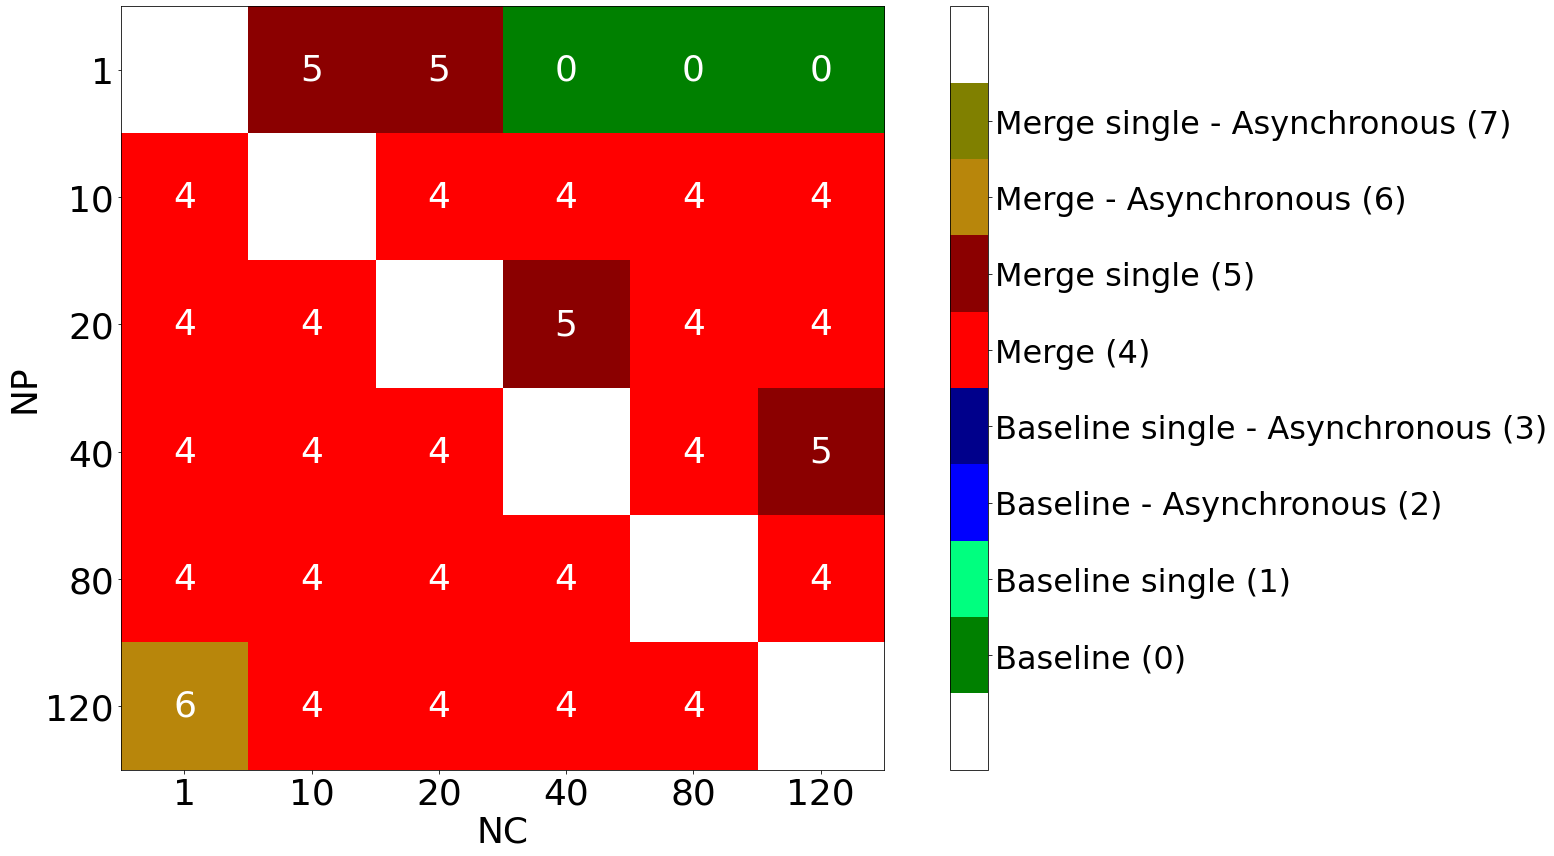

In [89]:
#Crea un heatmap teniendo en cuenta los colores anteriores
f=plt.figure(figsize=(24, 12))
ax=f.add_subplot(111)

myColors = (colors.to_rgba("white"),colors.to_rgba("green"), colors.to_rgba("springgreen"),colors.to_rgba("blue"),colors.to_rgba("darkblue"),
            colors.to_rgba("red"),colors.to_rgba("darkred"),colors.to_rgba("darkgoldenrod"),colors.to_rgba("olive"),colors.to_rgba("white"))
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

im = ax.imshow(heatmap,cmap=cmap,interpolation='nearest')

# Loop over data dimensions and create text annotations.
used_aux=0
for i in range(len(processes)):
    for j in range(len(processes)):
        if i!=j:
            aux_color="white"
            if heatmap[i, j] == 1: # El 1 puede necesitar texto en negro
                aux_color="black"
            results_index = i*len(processes) +j-used_aux
            if len(results_str[results_index]) == 1:
                text = results_str[results_index][0]
                ax.text(j, i, text, ha="center", va="center", color=aux_color, fontsize=36)
            else:
                add_aux = 0.33
                for line in range(len(results_str[results_index])):
                    i_range = i - 0.5 + add_aux
                    ax.text(j, i_range, results_str[results_index][line],
                            ha="center", va="center", color=aux_color, fontsize=36)
                    add_aux+=0.33
        else:
            used_aux+=1

ax.set_ylabel("NP", fontsize=36)
ax.set_xlabel("NC", fontsize=36)

ax.set_xticklabels(['']+processes, fontsize=36)
ax.set_yticklabels(['']+processes, fontsize=36)

#
labelsMethods_aux = ['Baseline (0)', 'Baseline single (1)','Baseline - Asynchronous (2)','Baseline single - Asynchronous (3)',
                 'Merge (4)','Merge single (5)','Merge - Asynchronous (6)','Merge single - Asynchronous (7)']
colorbar=f.colorbar(im, ax=ax)
colorbar.set_ticks([0.35, 1.25, 2.15, 3.05, 3.95, 4.85, 5.75, 6.65]) #TE
#colorbar.set_ticks([-2.55, 0.35, 1.25, 2.15, 3.05, 3.95, 4.85, 5.75, 6.65]) #TC
colorbar.set_ticklabels(labelsMethods_aux)
colorbar.ax.tick_params(labelsize=32)
#

f.tight_layout()
f.savefig("Images/Spawn/Heatmap_"+tipo+".png", format="png")

[11.986845, 3.995615, 3.995615, 3.995615, 3.995615, 3.995615]
[0, 0.0009824999999999999, 0.4770405, 0.766185, 0.8609199999999999, 0.890894]
[0, 79.98284, 3.99641, 1.99956, 0.9997100000000001, 0.6615499999999999]


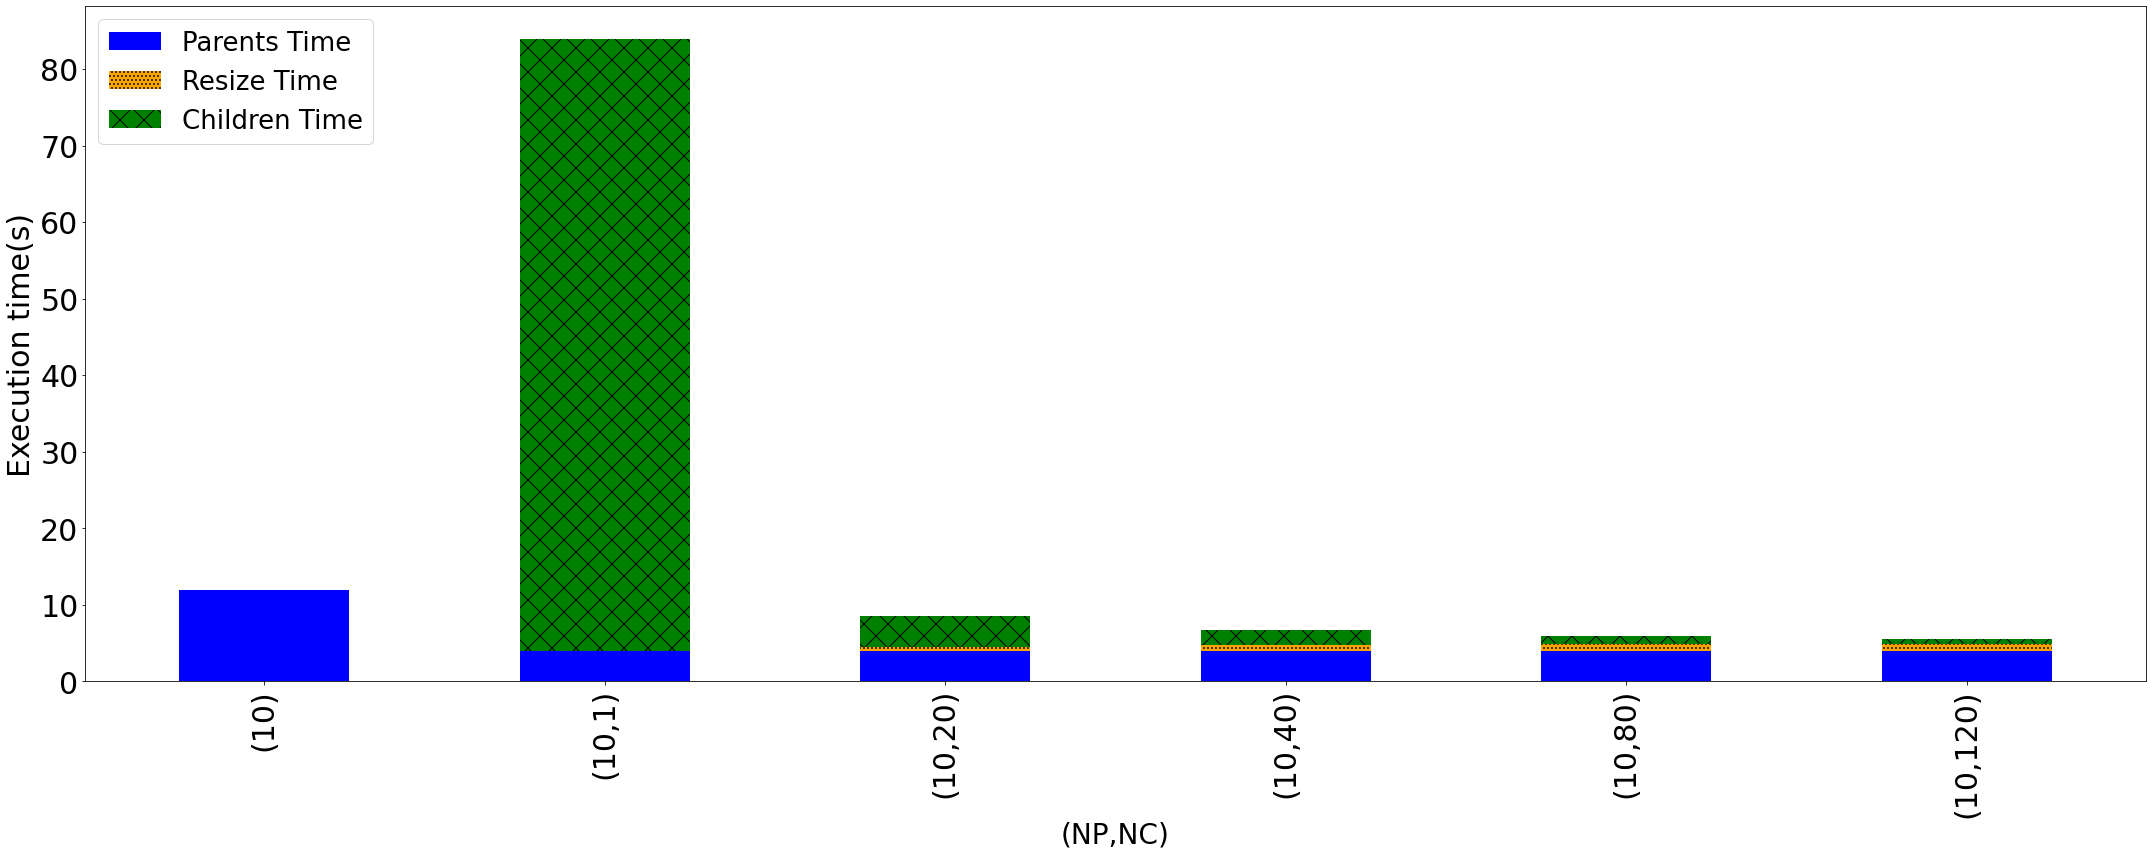

In [77]:
aux_labels = ['(10)', '(10,1)', '(10,20)', '(10,40)','(10,80)','(10,120)']
aux_values = [1, 20, 40, 80, 120]
title_y="Execution time(s)"
title_x="(NP,NC)"
maxiters_aux = 30
iters_aux1 = 10
iters_aux2 = 20
aggM_aux = grouped_aggM.query('NP == 10').query('Cst == 2').query('Css == 0')['TR'].values
aux1 = grouped_aggL.query('NP == 10').query('Cst == 2').query('Css == 0').query('NS == 1')
aux2 = grouped_aggL.query('NS == 10').query('Cst == 2').query('Css == 0')

data_aux1 = [aux1['Ti'].values[0] * maxiters_aux]
data_aux2 = [0]
data_aux3 = [0]
for i in range(len(aux_labels)-1):
    data_aux1.append(aux1['Ti'].values[0] * iters_aux1)
    data_aux2.append(aggM_aux[i])
    aux_value = aux_values[i]
    data_aux3.append(aux2.query('NP == @aux_value')['Ti'].values[0] * iters_aux2)
print(data_aux1)
print(data_aux2)
print(data_aux3)
sum_aux = np.add(data_aux1, data_aux2).tolist()

f=plt.figure(figsize=(30, 12))
ax=f.add_subplot(111)
x = np.arange(len(aux_labels))
width = 0.5
blue_Spatch = mpatches.Patch(facecolor='blue', label='Parents Time')
orange_Spatch = mpatches.Patch(hatch='...',facecolor='orange', label='Resize Time')
green_Spatch = mpatches.Patch(hatch='\\/',facecolor='green', label='Children Time')
handles=[blue_Spatch,orange_Spatch,green_Spatch]

ax.bar(x, data_aux1, width, color='blue')
ax.bar(x, data_aux2, width, bottom=data_aux1,color='orange', hatch='...')
ax.bar(x, data_aux3, width, bottom=sum_aux,color='green', hatch='\\/')

ax.set_ylabel(title_y, fontsize=30)
ax.set_xlabel(title_x, fontsize=28)
plt.xticks(x, aux_labels, rotation=90)
#plt.yscale("log")
    
ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=28)
plt.legend(handles=handles, loc='upper left', fontsize=26)

    
f.tight_layout()
f.savefig("Images/malleabilityTest.png", format="png")

In [5]:
processes = [2,10,20,40,80,120,160,200]
removed= []

#Audik
aux_real = [[171.737683, 171.721757, 171.712188, 172.025576, 171.824876, 172.195573, 172.085584, 172.184726, 171.713528, 172.086622, 172.066681, 172.964532, 172.229674, 171.916479, 171.984405, 172.127481, 171.669226, 171.739088, 171.974926, 171.751413], [68.331026, 68.713697, 68.206408, 67.885963, 68.693203, 68.568758, 68.54315, 68.511886, 68.390384, 68.5941, 68.464007, 68.369401, 68.422746, 68.535845, 68.503719, 68.404653, 68.792502, 68.477037, 68.512661, 68.559632], [40.694064, 40.989289, 40.742276, 41.025095, 40.863411, 41.005171, 40.705705, 42.076044, 40.49322, 40.933576, 40.632797, 41.346974, 42.414697, 39.96742, 40.927754, 39.910709, 39.778547, 40.712781, 41.478955, 40.403166], [30.04606, 29.085335, 27.345307, 30.238709, 34.168857, 29.744953, 27.631665, 28.170737, 27.113985, 27.96026, 29.121938, 29.229577, 27.341234, 27.349849, 29.133614, 27.205169, 30.273867, 28.97881, 30.29552, 29.045342], [23.08803, 23.585224, 23.425999, 22.946976, 25.210113, 23.013397, 23.421095, 22.66769, 24.621629, 23.740202, 24.069326, 24.87756, 24.931077, 24.022584, 23.596376, 22.101887, 22.086059, 23.988373, 22.905784, 22.300686], [20.578533, 21.146572, 23.113501, 22.796446, 27.166076, 21.821828, 21.016317, 23.468519, 19.655022, 23.826594, 21.723859, 24.282099, 24.850651, 26.058704, 21.709948, 20.57436, 21.496566, 22.860724, 25.819541, 23.12921], [25.043008, 24.306459, 22.952676, 23.921501, 23.581935, 24.324931, 27.242627, 22.308218, 24.807042, 26.235116, 22.731008, 21.579133, 21.154274, 23.548367, 27.395588, 23.154962, 23.773857, 26.417468, 23.717991, 25.39742], [24.616342, 24.039981, 24.206909, 24.654299, 28.106219, 26.687135, 23.869267, 24.097884, 25.629433, 27.700148, 25.425307, 26.413679, 25.972044, 25.791893, 25.866064, 24.27758, 25.591149, 26.614081, 26.93407, 29.430697]]
aux_sint = [[171.134606, 171.096637, 171.138184, 171.13844, 171.098454, 171.162362, 171.082225, 171.079004, 171.114536, 171.227906, 171.071966, 171.130859, 171.104273, 171.07788, 171.072194, 171.069075, 171.140295, 171.174013, 171.25217, 171.117231], [67.571535, 67.520025, 68.079664, 66.738064, 67.532297, 68.069914, 68.139622, 68.190914, 68.243213, 67.492165, 68.112115, 68.059658, 68.160322, 68.085698, 67.525525, 68.187291, 68.02039, 68.176564, 67.980121, 68.312952], [42.473247, 45.53225, 43.409906, 42.42814, 42.118484, 41.443236, 42.156082, 42.256023, 42.111314, 41.603221, 42.184052, 40.928944, 42.07551, 40.908719, 44.262672, 43.524809, 43.537822, 39.367229, 42.1689, 42.298479], [], [26.457291, 24.824646, 33.71007, 25.375645, 25.186218, 26.786703, 26.456784, 23.513595, 30.993635, 24.907237, 24.459753, 30.953045, 25.399975, 27.167862, 27.861115, 27.324158, 26.498797, 29.3722, 26.955239, 20.790296], [26.147293, 27.675856, 25.173467, 25.416053, 25.663571, 25.885352, 26.732089, 26.314055, 28.788113, 23.810305, 26.504224, 25.912384, 27.372798, 29.319178, 28.562837, 23.406136, 27.48343, 28.364868, 28.199635, 26.765826], [30.542833, 36.02513, 29.552827, 29.877948, 35.743363, 29.331332, 31.847175, 34.500058, 26.578159, 32.713294, 34.322071, 29.951176, 32.658056, 34.987492, 28.456334, 34.068832, 30.607325, 29.413311, 30.532202, 30.318787], [32.60606, 25.885468, 33.127615, 33.713661, 31.726036, 31.823991, 32.649191, 30.652817, 30.046183, 37.428624, 29.665286, 38.247098, 33.328042, 35.135827, 34.260634, 28.044284, 36.702605, 33.427365, 32.09166, 28.789384]]

#Queen
#aux_real = [[640.313059, 643.368851, 644.812491, 642.399734, 642.226814, 642.35475, 643.609192, 643.139744, 643.61705, 643.132647, 643.070286, 641.406328, 643.896836, 643.121044, 643.905589, 643.581402, 643.184715, 642.431289, 643.143977, 641.346561], [152.345899, 151.53339, 149.128109, 151.998913, 149.090488, 151.955341, 151.659499, 149.203061, 150.377392, 152.248175, 151.157503, 150.235083, 151.598016, 148.938792, 150.996531, 152.080666, 152.054726, 152.084692, 149.608602, 152.129981], [101.902944, 104.00788, 111.700969, 104.470693, 107.641521, 109.437217, 105.494903, 105.986737, 112.172214, 107.554958, 105.88158, 103.885249, 104.048641, 109.519779, 104.72926, 106.655908, 112.435562, 109.019183, 109.924859, 106.986846], [85.844223, 90.53081, 92.977514, 86.023776, 89.785998, 91.638115, 88.630006, 95.970387, 88.875131, 86.355962, 90.481832, 91.073597, 97.963737, 84.313078, 95.048194, 95.72992, 89.552759, 89.888328, 91.38958, 87.145446], [83.436137, 83.105543, 85.827104, 87.823647, 78.886258, 76.341861, 80.18113, 79.869432, 79.663487, 84.819399, 81.543829, 76.885674, 78.460587, 78.630554, 87.104227, 77.991342, 77.524938, 86.127078, 74.564246, 81.977689], [85.21399, 78.378531, 84.526313, 84.21782, 84.658752, 77.547238, 81.649375, 82.462926, 81.282893, 88.414904, 86.387445, 78.367787, 85.032026, 75.91001, 81.139097, 84.108863, 82.793723, 80.279569, 81.509798, 74.677693], [85.845828, 93.088063, 85.805088, 85.299568, 87.980509, 83.421145, 77.985249, 81.953544, 80.678587, 89.825371, 89.70287, 87.75817, 78.578479, 81.567104, 86.481628, 81.899106, 87.496995, 81.568352, 87.55542, 79.566851], [96.258907, 82.779222, 94.729087, 87.904027, 82.401901, 84.358796, 81.886275, 84.079098, 100.73735, 89.685091, 86.394575, 80.389717, 81.828049, 86.734577, 82.226097, 85.730868, 92.968317, 84.245582, 91.952588, 86.288488]]
#aux_sint = [[641.085136, 641.141923, 640.777817, 641.301842, 640.976289, 641.020807, 640.8895, 641.161191, 641.071841, 641.100684, 641.182133, 641.304331, 641.05437, 641.227479, 641.203772, 641.015224, 640.991178, 641.13879, 641.230584, 640.926491], [147.558438, 151.115339, 150.933246, 151.395058, 151.546527, 150.531321, 150.06193, 150.472433, 150.003948, 149.91831, 150.517089, 150.229956, 150.597576, 150.082463, 150.86667, 150.090303, 150.422634, 150.671741, 150.672547, 150.238191], [108.25061, 111.097101, 104.213767, 110.52693, 112.378777, 119.460641, 112.216745, 104.715758, 108.586798, 118.500656, 111.702574, 107.967457, 110.703181, 110.870681, 113.971439, 114.412381, 108.385472, 108.404177, 107.221267, 107.396806], [96.21288, 88.36866, 85.354348, 87.616739, 89.807877, 90.15373, 88.666607, 91.701534, 89.501369, 95.262825, 87.00914, 96.041417, 94.04346, 84.264348, 86.212998, 86.943123, 90.104903, 89.290074, 104.344068, 88.445732], [79.012331, 76.963467, 93.635579, 79.515014, 82.320548, 74.996362, 78.712431, 72.23961, 77.006344, 90.117262, 79.983322, 85.569436, 88.489679, 75.017607, 84.355796, 80.785074, 83.582964, 75.955045, 74.408056, 76.856599], [86.036661, 90.114675, 81.199959, 92.82014, 91.197787, 84.41333, 82.947796, 77.121997, 86.190024, 78.995126, 81.440768, 84.931682, 84.696228, 88.9819, 67.965288, 90.338966, 79.17985, 82.231772, 84.687085, 75.87027], [94.179702, 98.994605, 93.155944, 102.084059, 90.722862, 102.024703, 97.968444, 101.484367, 85.187726, 87.207102, 86.122057, 76.514077, 95.983665, 100.865989, 98.479677, 105.413981, 106.241153, 106.36522, 83.973521, 80.865762], [98.877075, 86.054865, 109.090461, 100.612676, 90.638634, 83.918211, 100.890697, 98.085722, 95.14564, 100.055308, 93.566746, 111.359513, 107.407847, 101.431541, 112.982436, 100.120412, 95.134338, 96.016258, 91.694929, 93.917124]]


#TEST Codigo sin captura de tiempos
#Codigo sin captura
#aux_sint = [[172.04165, 166.565937, 174.073495, 175.127555, 171.268598, 179.163764, 173.093602, 173.310969, 173.688159, 176.989948], [68.426733, 68.518644, 67.934562, 67.770617, 68.418071, 68.441444, 68.489923, 68.576862, 68.357891, 68.507931], [42.795763, 40.645969, 43.651983, 44.816286, 41.884911, 40.704261, 41.76031, 43.314722, 43.712624, 41.83065], [34.192324, 34.384576, 34.783733, 30.904571, 33.712345, 29.96747, 34.664818, 34.72399, 28.920618, 29.126176], [33.248177, 33.448689, 33.0446, 29.792059, 30.750121, 29.591303, 29.085716, 30.602103, 31.814472, 30.39379], [35.421251, 28.404227, 30.464738, 31.917447, 33.279842, 30.914243, 28.864047, 31.015124, 31.052509, 27.903691], [37.979388, 33.597368, 38.465519, 37.411409, 42.863337, 36.253646, 39.904695, 46.736134, 37.887813, 39.185104], []]
#Codigo con captura
#aux_real = [[172.23061, 172.274031, 172.224975, 172.199288, 172.142126, 172.133047, 172.262196, 172.206232, 172.197641, 172.201656], [67.729525, 68.280772, 68.348186, 68.354578, 68.405148, 68.548252, 68.404705, 68.461352, 68.347126, 68.37433], [48.270716, 43.616036, 42.091586, 41.417283, 42.089665, 41.92953, 42.563296, 41.799318, 40.910303, 45.403695], [34.600393, 31.826466, 32.053285, 30.025669, 30.139128, 32.118884, 35.913205, 33.58797, 31.433738, 30.869531], [36.761911, 27.334207, 32.128742, 27.013322, 24.008163, 29.872332, 28.812638, 31.073714, 30.33739, 30.352381], [29.629487, 25.729118, 29.081673, 29.723521, 29.247765, 35.299698, 31.711029, 31.346167, 30.085182, 27.99439], [42.031709, 41.964477, 33.98214, 37.872788, 34.108217, 37.903346, 41.666486, 37.516745, 39.800734, 35.537407], []]


In [6]:
#TODO Guardar funcion como comparacion de dos datos
normality = [True]*len(processes)
variance = [True]*len(processes)
results = [True]*len(processes)
# Check for assumption of normality
for i in range(len(processes)):
    if(processes[i] in removed):
        continue
        
    st,p = stats.shapiro(aux_real[i])
    if p < p_value:
        normality[i]=False
        continue
    st,p = stats.shapiro(aux_sint[i])
    if p < p_value:
        normality[i]=False

# Check for assumption of homoestacity
if True in normality: # Only needed for normal distributions
    for i in range(len(processes)):
        if(processes[i] in removed):
            continue
        st,p = stats.bartlett(aux_real[i],aux_sint[i])
        if p < p_value:
            variance[i] = False
    
# Check if groups are equal (True) or not (False)
for i in range(len(processes)):
    if(processes[i] in removed):
        continue
        
    if normality[i]:
        st,p = stats.ttest_ind(aux_real[i], aux_sint[i], equal_var=variance[i])
    else:
        st,p = stats.mannwhitneyu(aux_real[i], aux_sint[i])
    if p < p_value:
        results[i]=False

for i in range(len(processes)):
    if(processes[i] in removed):
        continue
    
    print("Para "+str(processes[i])+" los grupos son =="+str(results[i])+"== Normal-->"+str(normality[i])+"<-- Varianza-->"+str(variance[i])+"<--" )

ValueError: `x` and `y` must be of nonzero size.

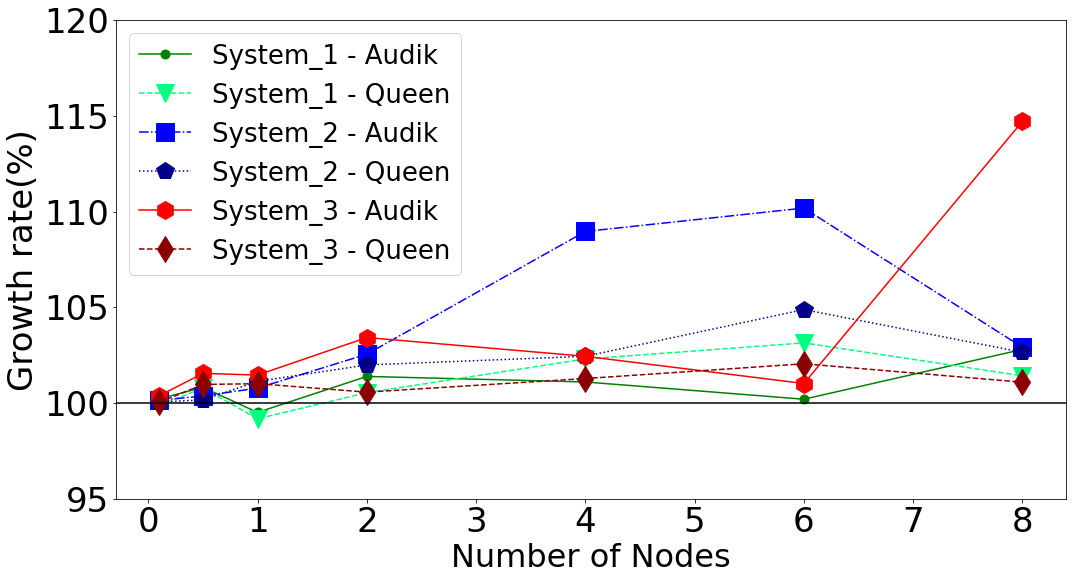

In [7]:
processes = [2,10,20,40,80,120,160]
aux_cores = 20
title_y="Growth rate(%)"
title_x="Number of Nodes"
aux_labels = ['System_1 - Audik', 'System_1 - Queen', 'System_2 - Audik', 'System_2 - Queen', 'System_3 - Audik', 'System_3 - Queen']
#aux_labels = ['System_1', 'System_2', 'System_3']
data1 = [100.22, 100.82, 99.51, 101.39, 101.10, 100.20, 102.80]
data2 = [99.88, 100.78, 99.18, 100.54, 102.30, 103.14, 101.42]
data3 = [100.14, 100.37, 100.78, 102.55, 108.96, 110.18, 102.91]
data4 = [100.06, 100.16, 101.13, 101.99, 102.44, 104.88, 102.65]
data5 = [100.38, 101.55, 101.46, 103.42, 102.44, 101.02, 114.71]
data6 = [100.03, 100.97, 101.01, 100.57, 101.28, 102.05, 101.09]


data_x = [data1, data2, data3, data4, data5, data6]
#data_x = [data2, data4, data6]
style_aux=0

nodes = []
for i in range(len(processes)):
    nodes.append(processes[i]/aux_cores)

f=plt.figure(figsize=(15, 8))
ax=f.add_subplot(111)

for i in range(len(data_x)):
    ax.plot(nodes, data_x[i], color=colors_spawn[i], linestyle=linestyle_spawn[i%4], \
                marker=markers_spawn[i], markersize=18, label=aux_labels[i])
ax.axhline((100), color='black')

ax.set_ylabel(title_y, fontsize=34)
ax.set_xlabel(title_x, fontsize=32)
    
ax.tick_params(axis='both', which='major', labelsize=34)
ax.tick_params(axis='both', which='minor', labelsize=32)
plt.legend(loc='best', fontsize=26)

    
f.tight_layout()
ax.set_ylim(95,120)
f.savefig("Images/malleabilityTest.png", format="png")

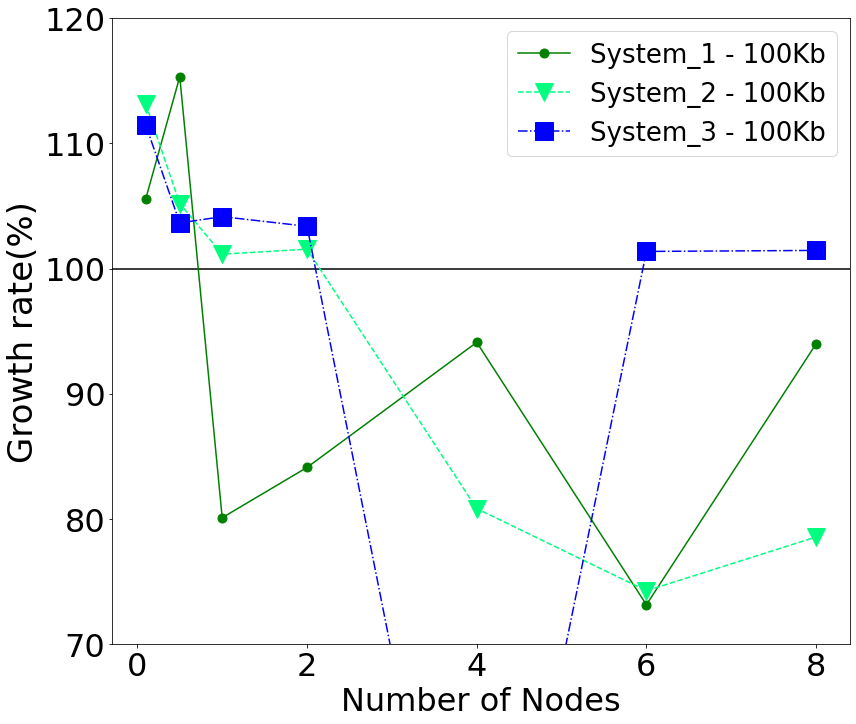

In [40]:
processes = [2,10,20,40,80,120,160]
aux_cores = 20
title_y="Growth rate(%)"
title_x="Number of Nodes"
aux_labels = ['System_1 - 100Kb', 'System_1 - 10Mb', 'System_1 - 1Gb', 'System_2 - 100Kb', 'System_2 - 10Mb', 'System_2 - 1Gb', 'System_3 - 100Kb', 'System_3 - 10Mb', 'System_3 - 1Gb']
data1 = [105.60, 115.34, 80.08, 84.10, 94.10, 73.12, 93.98]
data2 = [97.37, 104.83, 98.73, 98.90, 94.63, 95.37, 98.02]
data3 = [98.55, 97.01, 97.88, 99.05, 102.10, 98.74, 97.85]
data4 = [113.15, 105.19, 101.15, 101.55, 80.81, 74.24, 78.54]
data5 = [100.60, 99.13, 99.95, 96.98, 106.92, 84.42, 89.66]
data6 = [98.88, 100.26, 100.05, 117.63, 103.59, 100.41, 106.25]
data7 = [111.45, 103.65, 104.15, 103.38, 35.09, 101.37, 101.45]
data8 = [101.44, 99.65, 99.24, 100.66, 105.61, 101.14, 101.67]
data9 = [101.07, 99.99, 102.25, 100.46, 100.91, 100.53, 102.18]

error1 = [1.51E-01, 2.09E-01, 4.80E-01, 3.93E-01, 2.68E-01, 1.45E-01, 2.35E-01]
error2 = [1.86E-02, 6.31E-02, 7.68E-02, 1.10E-01, 8.33E-02, 5.99E-02, 6.94E-02]
error3 = [1.83E-02, 8.26E-02, 3.11E-02, 2.86E-02, 4.14E-02, 3.26E-02, 3.73E-02]
error4 = [2.23E-02, 6.10E-03, 4.08E-03, 6.32E-03, 4.99E-02, 9.55E-02, 1.01E-01]
error5 = [1.21E-02, 1.61E-02, 8.52E-03, 3.12E-02, 1.15E-01, 5.49E-02, 4.70E-02]
error6 = [2.46E-02, 5.21E-03, 1.34E-03, 1.16E-01, 6.07E-02, 1.12E-02, 7.64E-02]
error7 = [3.71E-02, 3.67E-03, 3.89E-03, 3.48E-02, 3.76E-03, 1.03E-02, 7.90E-03]
error8 = [1.79E-02, 5.02E-03, 6.63E-03, 2.94E-03, 5.25E-02, 1.67E-02, 8.36E-03]
error9 = [7.47E-03, 2.25E-03, 1.64E-02, 5.94E-03, 2.85E-02, 3.22E-03, 2.54E-02]

#data_x = [data1, data2, data3, data4, data5, data6, data7, data8, data9]
#error_x = [error1, error2, error3, error4, error5, error6, error7, error8, error9]

data_x = [data1, data4, data7]
error_x = [error1, error2, error3]
aux_labels = ['System_1 - 100Kb', 'System_2 - 100Kb', 'System_3 - 100Kb']

#data_x = [data2, data5, data8]
#error_x = [error4, error5, error6]
#aux_labels = ['System_1 - 10Mb', 'System_2 - 10Mb', 'System_3 - 10Mb']

#data_x = [data3, data6, data9]
#error_x = [error7, error8, error9]
#aux_labels = ['System_1 - 1Gb', 'System_2 - 1Gb', 'System_3 - 1Gb']

style_aux=0

nodes = []
for i in range(len(processes)):
    nodes.append(processes[i]/aux_cores)

f=plt.figure(figsize=(12, 10))
ax=f.add_subplot(111)

for i in range(len(data_x)):
    ax.errorbar(nodes, data_x[i], color=colors_spawn[i%9], linestyle=linestyle_spawn[i%4], \
                marker=markers_spawn[i%9], markersize=18, label=aux_labels[i])
    #ax.errorbar(nodes, data_x[i], yerr=error_x[i], color=colors_spawn[i%8], linestyle=linestyle_spawn[i%4], \
    #            marker=markers_spawn[i%8], markersize=18, label=aux_labels[i])
    #ax.errorbar(nodes, data_x[i], yerr=error_x[i], color=colors_spawn[i%8], linestyle=linestyle_spawn[i%4], \
     #           label=aux_labels[i])
ax.axhline((100), color='black')

ax.set_ylabel(title_y, fontsize=34)
ax.set_xlabel(title_x, fontsize=32)
    
ax.tick_params(axis='both', which='major', labelsize=32)
ax.tick_params(axis='both', which='minor', labelsize=30)
plt.legend(loc='best', fontsize=26)

    
f.tight_layout()
ax.set_ylim(70,120)
f.savefig("Images/malleabilityTest.png", format="png")

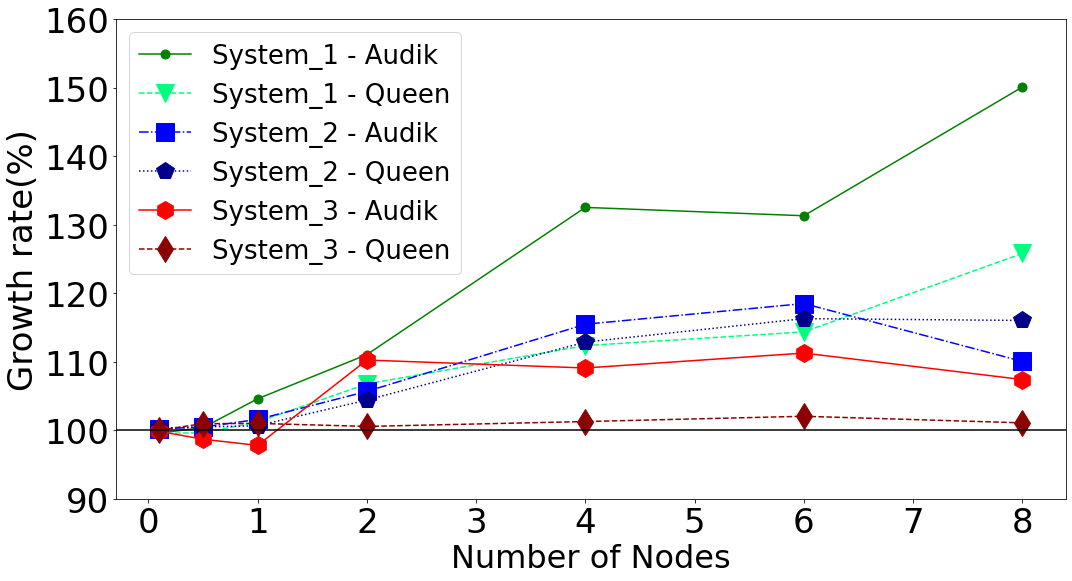

In [15]:
processes = [2,10,20,40,80,120,160]
aux_cores = 20
title_y="Growth rate(%)"
title_x="Number of Nodes"
aux_labels = ['System_1 - Audik', 'System_1 - Queen', 'System_2 - Audik', 'System_2 - Queen', 'System_3 - Audik', 'System_3 - Queen']
data1 = [99.60, 100.38, 104.60, 111.05, 132.55, 131.33, 150.13]
data2 = [99.57, 99.63, 101.22, 106.77, 112.37, 114.37, 125.83]
data3 = [100.22, 100.47, 101.59, 105.68, 115.49, 118.51, 110.06]
data4 = [100.32, 100.49, 100.67, 104.42, 112.88, 116.31, 116.04]
data5 = [100.31, 102.19, 101.88, 108.02, 106.44, 104.87, 111.85]
data5 = [99.85, 98.70, 97.80, 110.26, 109.10, 111.28, 107.41]



data_x = [data1, data2, data3, data4, data5, data6]

style_aux=0

nodes = []
for i in range(len(processes)):
    nodes.append(processes[i]/aux_cores)

f=plt.figure(figsize=(15, 8))
ax=f.add_subplot(111)

for i in range(len(data_x)):
    ax.plot(nodes, data_x[i], color=colors_spawn[i], linestyle=linestyle_spawn[i%4], \
                marker=markers_spawn[i], markersize=18, label=aux_labels[i])
ax.axhline((100), color='black')

ax.set_ylabel(title_y, fontsize=34)
ax.set_xlabel(title_x, fontsize=32)
    
ax.tick_params(axis='both', which='major', labelsize=34)
ax.tick_params(axis='both', which='minor', labelsize=32)
plt.legend(loc='best', fontsize=26)

    
f.tight_layout()
ax.set_ylim(90,160)
f.savefig("Images/malleabilityTest.png", format="png")